# Optimal Pricing Strategy for Quick Sales


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
import re
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder,  OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMClassifier

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
import warnings

In [3]:
file_path = r"C:\Users\omnia\Google Drive\Springboard\Assigments\Capestone 3\Optimal Pricing Strategy for Quick Sales\Wesley Chapel Agent Single Line CSV.csv"
WC_data = pd.read_csv(file_path)

In [4]:
WC_data.head()

,#,ML Number,Status,Address,City,Zip,Legal Subdivision Name,Subdivision/Condo Name,Heated Area,Current Price,...,Ownership,Tax,CDOM,ADOM,Days to Contract,Sold Terms,Close Date,LP / SqFt,SP/SqFt,SP / LP
0,1.0,W7870804,ACT,3844 KIM DR,WESLEY CHAPEL,33543.0,TERRACE PARK 01,NaN,576,"$105,500",...,Fee Simple,$321.00,35.0,35.0,NaN,NaN,NaN,$183.16,NaN,NaN
1,2.0,TB8329083,ACT,33843 TERRACE BLVD,WESLEY CHAPEL,33543.0,TERRACE PARK 02,NaN,864,"$134,900",...,Fee Simple,$215.58,34.0,34.0,NaN,NaN,NaN,$156.13,NaN,NaN
2,3.0,TB8330243,ACT,3836 CHRIS DR,WESLEY CHAPEL,33543.0,TERRACE PARK 02,NaN,600,"$139,900",...,Fee Simple,"$1,732.00",13.0,13.0,NaN,NaN,NaN,$233.17,NaN,NaN
3,4.0,O6263571,ACT,3145 HIDDEN LAKE DR,WESLEY CHAPEL,33543.0,TIMBER LAKE ESTATES,NaN,864,"$146,000",...,Condominium,$466.15,160.0,41.0,NaN,NaN,NaN,$168.98,NaN,NaN
4,5.0,TB8322494,ACT,33821 TERRACE BLVD,WESLEY CHAPEL,33543.0,TERRACE PARK,NaN,"1,620","$169,900",...,Fee Simple,$271.00,63.0,63.0,NaN,NaN,NaN,$104.88,NaN,NaN


In [5]:
WC_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   #                       5000 non-null   float64
 1   ML Number               5000 non-null   object 
 2   Status                  5000 non-null   object 
 3   Address                 5000 non-null   object 
 4   City                    5000 non-null   object 
 5   Zip                     5000 non-null   float64
 6   Legal Subdivision Name  4994 non-null   object 
 7   Subdivision/Condo Name  5 non-null      object 
 8   Heated Area             4975 non-null   object 
 9   Current Price           5000 non-null   object 
 10  Beds                    5000 non-null   float64
 11  Full Baths              5000 non-null   float64
 12  Half Baths              5000 non-null   float64
 13  Year Built              5000 non-null   float64
 14  Pool                    3462 non-null   

In [6]:
# Drop columns
columns_to_drop = ['#', 'ML Number', 'Address', 'Zip', 'Subdivision/Condo Name', 'Ownership', 'Tax']
WC_data = WC_data.drop(columns=columns_to_drop)
WC_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Status                  5000 non-null   object 
 1   City                    5000 non-null   object 
 2   Legal Subdivision Name  4994 non-null   object 
 3   Heated Area             4975 non-null   object 
 4   Current Price           5000 non-null   object 
 5   Beds                    5000 non-null   float64
 6   Full Baths              5000 non-null   float64
 7   Half Baths              5000 non-null   float64
 8   Year Built              5000 non-null   float64
 9   Pool                    3462 non-null   object 
 10  Property Style          5000 non-null   object 
 11  CDOM                    5000 non-null   float64
 12  ADOM                    5000 non-null   float64
 13  Days to Contract        4174 non-null   object 
 14  Sold Terms              3935 non-null   

In [7]:
# Clean special caracters 
columns_to_clean = ['Current Price', 'LP / SqFt', 'SP/SqFt', 'Heated Area']
for column in columns_to_clean:
    WC_data[column] = WC_data[column].replace(r'[\$]', '', regex=True).replace(',', '', regex=True).astype(float)

WC_data.info()
WC_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Status                  5000 non-null   object 
 1   City                    5000 non-null   object 
 2   Legal Subdivision Name  4994 non-null   object 
 3   Heated Area             4975 non-null   float64
 4   Current Price           5000 non-null   float64
 5   Beds                    5000 non-null   float64
 6   Full Baths              5000 non-null   float64
 7   Half Baths              5000 non-null   float64
 8   Year Built              5000 non-null   float64
 9   Pool                    3462 non-null   object 
 10  Property Style          5000 non-null   object 
 11  CDOM                    5000 non-null   float64
 12  ADOM                    5000 non-null   float64
 13  Days to Contract        4174 non-null   object 
 14  Sold Terms              3935 non-null   

,Status,City,Legal Subdivision Name,Heated Area,Current Price,Beds,Full Baths,Half Baths,Year Built,Pool,Property Style,CDOM,ADOM,Days to Contract,Sold Terms,Close Date,LP / SqFt,SP/SqFt,SP / LP
0,ACT,WESLEY CHAPEL,TERRACE PARK 01,576.0,105500.0,2.0,1.0,1.0,1973.0,NaN,Mobile Home - Pre 1976,35.0,35.0,NaN,NaN,NaN,183.16,NaN,NaN
1,ACT,WESLEY CHAPEL,TERRACE PARK 02,864.0,134900.0,2.0,1.0,0.0,1976.0,Community,Mobile Home - Pre 1976,34.0,34.0,NaN,NaN,NaN,156.13,NaN,NaN
2,ACT,WESLEY CHAPEL,TERRACE PARK 02,600.0,139900.0,1.0,1.0,0.0,2005.0,Community,Manufactured Home - Post 1977,13.0,13.0,NaN,NaN,NaN,233.17,NaN,NaN
3,ACT,WESLEY CHAPEL,TIMBER LAKE ESTATES,864.0,146000.0,2.0,2.0,0.0,1986.0,NaN,Mobile Home - Pre 1976,160.0,41.0,NaN,NaN,NaN,168.98,NaN,NaN
4,ACT,WESLEY CHAPEL,TERRACE PARK,1620.0,169900.0,2.0,2.0,0.0,1986.0,Community,Manufactured Home - Post 1977,63.0,63.0,NaN,NaN,NaN,104.88,NaN,NaN


In [8]:
# Convert Days to Contract & Heated Area to numeric 
WC_data[['Days to Contract', 'Heated Area']] = WC_data[['Days to Contract', 'Heated Area']].apply(pd.to_numeric, errors='coerce')

In [9]:
WC_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Status                  5000 non-null   object 
 1   City                    5000 non-null   object 
 2   Legal Subdivision Name  4994 non-null   object 
 3   Heated Area             4975 non-null   float64
 4   Current Price           5000 non-null   float64
 5   Beds                    5000 non-null   float64
 6   Full Baths              5000 non-null   float64
 7   Half Baths              5000 non-null   float64
 8   Year Built              5000 non-null   float64
 9   Pool                    3462 non-null   object 
 10  Property Style          5000 non-null   object 
 11  CDOM                    5000 non-null   float64
 12  ADOM                    5000 non-null   float64
 13  Days to Contract        4173 non-null   float64
 14  Sold Terms              3935 non-null   

In [10]:
# Converting Close date to date time
def safe_parse_date(date_str):
    try:
        return parser.parse(date_str)
    except Exception:
        return None

# Apply the function to the Close Date column
WC_data['Close Date'] = WC_data['Close Date'].apply(safe_parse_date)

print(WC_data['Close Date'].dtype)  

datetime64[ns]


In [11]:
WC_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Status                  5000 non-null   object        
 1   City                    5000 non-null   object        
 2   Legal Subdivision Name  4994 non-null   object        
 3   Heated Area             4975 non-null   float64       
 4   Current Price           5000 non-null   float64       
 5   Beds                    5000 non-null   float64       
 6   Full Baths              5000 non-null   float64       
 7   Half Baths              5000 non-null   float64       
 8   Year Built              5000 non-null   float64       
 9   Pool                    3462 non-null   object        
 10  Property Style          5000 non-null   object        
 11  CDOM                    5000 non-null   float64       
 12  ADOM                    5000 non-null   float64 

In [12]:
# Convert Close Date to datetime (handle NaN values)
WC_data['Close Date'] = pd.to_datetime(WC_data['Close Date'], errors='coerce')
WC_data['Close Date'].dtype

dtype('<M8[ns]')

In [13]:
# Handling missing values 
WC_data.loc[:, 'Pool'] = WC_data['Pool'].fillna('None')
WC_data.loc[:, 'Legal Subdivision Name'] = WC_data['Legal Subdivision Name'].fillna('Unknown')
WC_data.loc[:, 'Sold Terms'] = WC_data['Sold Terms'].fillna('Unknown')

In [14]:
status_count = WC_data['Status'].value_counts()
status_count

Status
SLD    3937
ACT     617
PND     237
EXP     209
Name: count, dtype: int64

In [15]:
# Drop rows with Nan in 'Status'
WC_data = WC_data.dropna(subset=['Status'])
WC_data.tail()

,Status,City,Legal Subdivision Name,Heated Area,Current Price,Beds,Full Baths,Half Baths,Year Built,Pool,Property Style,CDOM,ADOM,Days to Contract,Sold Terms,Close Date,LP / SqFt,SP/SqFt,SP / LP
4995,EXP,WESLEY CHAPEL,COUNTRY WALK INCREMENT C PH 02,2311.0,525000.0,4.0,2.0,1.0,2016.0,Community,Single Family Residence,43.0,43.0,NaN,Unknown,NaT,227.17,NaN,NaN
4996,EXP,WESLEY CHAPEL,EPPERSON NORTH,2615.0,589900.0,5.0,3.0,0.0,2022.0,Community,Single Family Residence,186.0,186.0,NaN,Unknown,NaT,225.58,NaN,NaN
4997,EXP,WESLEY CHAPEL,CIRCLE EIGHT PHASE 1,2756.0,650000.0,3.0,3.0,0.0,1982.0,None,Single Family Residence,313.0,313.0,NaN,Unknown,NaT,235.85,NaN,NaN
4998,EXP,WESLEY CHAPEL,EPPERSON RANCH SOUTH,2964.0,700000.0,5.0,3.0,0.0,2018.0,None,Single Family Residence,87.0,87.0,NaN,Unknown,NaT,236.17,NaN,NaN
4999,EXP,WESLEY CHAPEL,ACREAGE,6529.0,2450000.0,7.0,5.0,1.0,2023.0,Private,Single Family Residence,334.0,334.0,NaN,Unknown,NaT,375.25,NaN,NaN


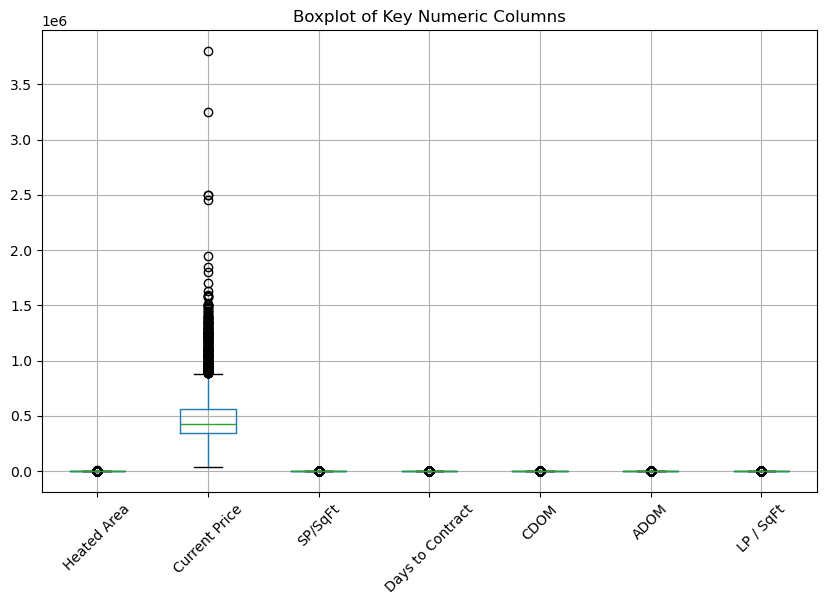

In [16]:
# Plot boxplot for key numeric columns
WC_data[['Heated Area', 'Current Price', 'SP/SqFt', 'Days to Contract', 'CDOM', 'ADOM', 'LP / SqFt']].boxplot(figsize=(10, 6))
plt.title('Boxplot of Key Numeric Columns')
plt.xticks(rotation=45)
plt.show()

In [17]:
WC_data['Current Price'].describe()

count    5.000000e+03
mean     4.864365e+05
std      2.242243e+05
min      4.000000e+04
25%      3.470000e+05
50%      4.309900e+05
75%      5.610288e+05
max      3.800000e+06
Name: Current Price, dtype: float64

In [18]:
# Define a function to detect outliers 
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 -Q1
    lower_bound = Q1 -1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR 

    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

In [19]:
price_outliers = detect_outliers(WC_data, 'Current Price')
print(price_outliers['Current Price'].describe())

count    2.460000e+02
mean     1.161865e+06
std      3.334775e+05
min      8.850000e+05
25%      9.499250e+05
50%      1.099450e+06
75%      1.263750e+06
max      3.800000e+06
Name: Current Price, dtype: float64


In [20]:
# Remove duplicate rows from WC_data
WC_data = WC_data.drop_duplicates()

print(f"Number of rows after removing duplicates: {WC_data.shape[0]}")
print(f"Remaining duplicate rows: {WC_data.duplicated().sum()}")

Number of rows after removing duplicates: 4991
Remaining duplicate rows: 0


In [21]:
#Seprate the data
act_data = WC_data[WC_data['Status'] == 'ACT']
pnd_data = WC_data[WC_data['Status'] == 'PND']
exp_data = WC_data[WC_data['Status'] == 'EXP']
sold_data = WC_data[WC_data['Status'] == 'SLD']

In [22]:
# Extract month, year, day of the week
pd.options.mode.chained_assignment = None

sold_data.loc[:, 'Close Month'] = sold_data['Close Date'].dt.month
sold_data.loc[:, 'Close Year'] = sold_data['Close Date'].dt.year
sold_data.loc[:, 'Close Day of Week'] = sold_data['Close Date'].dt.day_name()

In [23]:
sold_data.head()

,Status,City,Legal Subdivision Name,Heated Area,Current Price,Beds,Full Baths,Half Baths,Year Built,Pool,...,ADOM,Days to Contract,Sold Terms,Close Date,LP / SqFt,SP/SqFt,SP / LP,Close Month,Close Year,Close Day of Week
399,SLD,WESLEY CHAPEL,FOX RIDGE,1512.0,135000.0,2.0,2.0,0.0,1980.0,None,...,0.0,-24.0,Cash,2024-11-25,89.29,89.29,1.00,11,2024,Monday
400,SLD,WESLEY CHAPEL,MEADOW POINTE PRCL 16 UNIT 02B,1184.0,156000.0,2.0,2.0,1.0,2002.0,None,...,2.0,2.0,Cash,2025-01-02,139.36,131.76,0.95,1,2025,Thursday
401,SLD,WESLEY CHAPEL,FOX RIDGE,1344.0,175000.0,3.0,2.0,0.0,1983.0,None,...,3.0,3.0,Cash,2024-12-05,148.74,130.21,0.88,12,2024,Thursday
402,SLD,WESLEY CHAPEL,MEADOW POINTE PRCL 16 UNIT 3A,1240.0,225000.0,2.0,2.0,1.0,2004.0,Community,...,32.0,52.0,Conventional,2025-01-16,189.44,181.45,0.96,1,2025,Thursday
403,SLD,WESLEY CHAPEL,THE TOWNHOMES AT RIVER LANDING,1373.0,234300.0,3.0,2.0,1.0,2024.0,Community,...,0.0,-37.0,Conventional,2024-12-17,170.65,170.65,1.00,12,2024,Tuesday


In [24]:
# Remove rows with negative values
sold_data = sold_data.loc[sold_data['Days to Contract'] >= 0]
sold_data.describe()

,Heated Area,Current Price,Beds,Full Baths,Half Baths,Year Built,CDOM,ADOM,Days to Contract,Close Date,LP / SqFt,SP/SqFt,SP / LP,Close Month,Close Year
count,3328.000000,3.328000e+03,3328.000000,3328.000000,3328.000000,3328.000000,3328.000000,3328.000000,3328.000000,3328,3328.000000,3328.000000,3328.000000,3328.000000,3328.000000
mean,2149.963642,4.583267e+05,3.575721,2.386719,0.414363,2014.609075,47.879207,45.051082,50.645132,2024-04-02 08:47:01.153846272,216.116653,212.717819,0.984967,7.051382,2023.702825
min,226.000000,4.000000e+04,1.000000,1.000000,0.000000,1950.000000,-7.000000,-7.000000,0.000000,2023-03-29 00:00:00,30.660000,39.410000,0.470000,1.000000,2023.000000
25%,1672.000000,3.382595e+05,3.000000,2.000000,0.000000,2005.000000,9.000000,9.000000,11.000000,2023-11-27 00:00:00,189.117500,187.587500,0.980000,5.000000,2023.000000
50%,2006.500000,4.200000e+05,3.000000,2.000000,0.000000,2021.000000,31.000000,29.000000,33.000000,2024-04-17 00:00:00,211.105000,207.545000,1.000000,7.000000,2024.000000
75%,2515.500000,5.208850e+05,4.000000,3.000000,1.000000,2024.000000,71.250000,68.000000,76.000000,2024-08-09 00:00:00,235.022500,232.515000,1.000000,10.000000,2024.000000
max,5657.000000,1.850000e+06,7.000000,5.000000,2.000000,2025.000000,400.000000,400.000000,440.000000,2025-01-20 00:00:00,1891.550000,1891.550000,2.000000,12.000000,2025.000000
std,701.036892,1.866191e+05,0.846307,0.632573,0.501154,11.589751,51.370070,47.629220,52.483389,NaN,51.337819,50.563126,0.040425,3.302967,0.502202


In [25]:
# Define threshold for contract speed
def classify_contract_speed(days_to_contract):
    if days_to_contract <= 15:
        return 'Fast'
    elif days_to_contract <= 45:
        return 'Medium'
    else:
        return 'Slow'

sold_data['Contract Speed'] = sold_data['Days to Contract'].apply(classify_contract_speed)
sold_data['Contract Speed'].value_counts()

Contract Speed
Slow      1367
Fast      1058
Medium     903
Name: count, dtype: int64

In [26]:
# Seprate Luxury properties
lux_data = sold_data[(sold_data['Current Price'] >= 800000)]
sld_data = sold_data[sold_data['Current Price'] < 800000]

# Check the result
print(f"Number of luxury properties: {len(lux_data)}")  
print(f"Number of non-luxury properties: {len(sld_data)}")

Number of luxury properties: 167
Number of non-luxury properties: 3161


In [27]:
print(f"Total properties after separation: {len(lux_data) + len(sld_data)}")
print(f"Original number of properties: {len(sold_data)}")

Total properties after separation: 3328
Original number of properties: 3328


In [28]:
overlap = pd.merge(lux_data, sld_data, how='inner', on='Current Price')
print(f"Number of overlapping properties (should be 0): {len(overlap)}")


Number of overlapping properties (should be 0): 0


In [29]:
print(f"Luxury properties: Min price = {lux_data['Current Price'].min()}, Max price = {lux_data['Current Price'].max()}")
print(f"Non-luxury properties: Max price = {sld_data['Current Price'].max()}")

Luxury properties: Min price = 800000.0, Max price = 1850000.0
Non-luxury properties: Max price = 799900.0


In [30]:
print(f"Active Properties: {len(act_data)}")
print(f"Pending Properties: {len(pnd_data)}")
print(f"Sold Properties: {len(sold_data)}")
print(f"Expire Properties: {len(exp_data)}")
print(f"Luxury Properties: {len(lux_data)}")
print(f"Non Luxury Properties: {len(sld_data)}")

Active Properties: 608
Pending Properties: 237
Sold Properties: 3328
Expire Properties: 209
Luxury Properties: 167
Non Luxury Properties: 3161


In [31]:
sld_data['Current Price'].max()

799900.0

In [32]:
lux_data.head()

,Status,City,Legal Subdivision Name,Heated Area,Current Price,Beds,Full Baths,Half Baths,Year Built,Pool,...,Days to Contract,Sold Terms,Close Date,LP / SqFt,SP/SqFt,SP / LP,Close Month,Close Year,Close Day of Week,Contract Speed
491,SLD,WESLEY CHAPEL,WESTWOOD ESTATES,3000.0,937500.0,5.0,3.0,0.0,2024.0,None,...,7.0,Conventional,2024-11-25,312.50,312.50,1.00,11,2024,Monday,Fast
968,SLD,WESLEY CHAPEL,ESPLANADE AT WIREGRASS RANCH,3004.0,805000.0,4.0,3.0,0.0,2024.0,Community,...,58.0,Conventional,2024-12-11,274.63,267.98,0.98,12,2024,Wednesday,Slow
969,SLD,WESLEY CHAPEL,EPPERSON RANCH SOUTH PH 3B & 3,2706.0,809990.0,4.0,2.0,1.0,2019.0,"Private, Community",...,31.0,Conventional,2024-12-02,299.33,299.33,1.00,12,2024,Monday,Medium
971,SLD,WESLEY CHAPEL,ESPLANADE AT WIREGRASS RANCH,2275.0,830093.0,3.0,3.0,0.0,2024.0,None,...,0.0,Conventional,2024-08-21,364.88,364.88,1.00,8,2024,Wednesday,Fast
973,SLD,WESLEY CHAPEL,EPPERSON RANCH SOUTH PHASE 1A-2,3142.0,840000.0,4.0,3.0,1.0,2020.0,Community,...,54.0,Conventional,2025-01-15,270.53,267.35,0.99,1,2025,Wednesday,Slow


## Exploratory Data Analysis

In [34]:
# Summary of the sold dataset
sld_data.info()
sld_data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Index: 3161 entries, 400 to 4955
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Status                  3161 non-null   object        
 1   City                    3161 non-null   object        
 2   Legal Subdivision Name  3161 non-null   object        
 3   Heated Area             3161 non-null   float64       
 4   Current Price           3161 non-null   float64       
 5   Beds                    3161 non-null   float64       
 6   Full Baths              3161 non-null   float64       
 7   Half Baths              3161 non-null   float64       
 8   Year Built              3161 non-null   float64       
 9   Pool                    3161 non-null   object        
 10  Property Style          3161 non-null   object        
 11  CDOM                    3161 non-null   float64       
 12  ADOM                    3161 non-null   float64    

,Status,City,Legal Subdivision Name,Heated Area,Current Price,Beds,Full Baths,Half Baths,Year Built,Pool,...,Days to Contract,Sold Terms,Close Date,LP / SqFt,SP/SqFt,SP / LP,Close Month,Close Year,Close Day of Week,Contract Speed
count,3161,3161,3161,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3161,...,3161.000000,3161,3161,3161.000000,3161.000000,3161.00000,3161.000000,3161.000000,3161,3161
unique,1,1,600,NaN,NaN,NaN,NaN,NaN,NaN,4,...,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,7,3
top,SLD,WESLEY CHAPEL,EPPERSON RANCH,NaN,NaN,NaN,NaN,NaN,NaN,Community,...,NaN,Conventional,NaN,NaN,NaN,NaN,NaN,NaN,Friday,Slow
freq,3161,3161,263,NaN,NaN,NaN,NaN,NaN,NaN,2102,...,NaN,1593,NaN,NaN,NaN,NaN,NaN,NaN,926,1302
mean,NaN,NaN,NaN,2063.465359,428837.927871,3.523568,2.318570,0.408415,2014.521670,NaN,...,50.683644,NaN,2024-04-03 19:35:46.788990976,212.754752,209.536469,0.98541,7.052831,2023.706422,NaN,NaN
min,NaN,NaN,NaN,226.000000,40000.000000,1.000000,1.000000,0.000000,1950.000000,NaN,...,0.000000,NaN,2023-03-29 00:00:00,30.660000,39.410000,0.47000,1.000000,2023.000000,NaN,NaN
25%,NaN,NaN,NaN,1667.000000,334990.000000,3.000000,2.000000,0.000000,2005.000000,NaN,...,11.000000,NaN,2023-11-28 00:00:00,188.280000,186.660000,0.98000,5.000000,2023.000000,NaN,NaN
50%,NaN,NaN,NaN,1936.000000,410000.000000,3.000000,2.000000,0.000000,2021.000000,NaN,...,33.000000,NaN,2024-04-18 00:00:00,208.890000,205.250000,1.00000,7.000000,2024.000000,NaN,NaN
75%,NaN,NaN,NaN,2447.000000,499000.000000,4.000000,3.000000,1.000000,2024.000000,NaN,...,76.000000,NaN,2024-08-12 00:00:00,232.210000,230.230000,1.00000,10.000000,2024.000000,NaN,NaN
max,NaN,NaN,NaN,4266.000000,799900.000000,6.000000,5.000000,2.000000,2025.000000,NaN,...,440.000000,NaN,2025-01-20 00:00:00,1891.550000,1891.550000,2.00000,12.000000,2025.000000,NaN,NaN


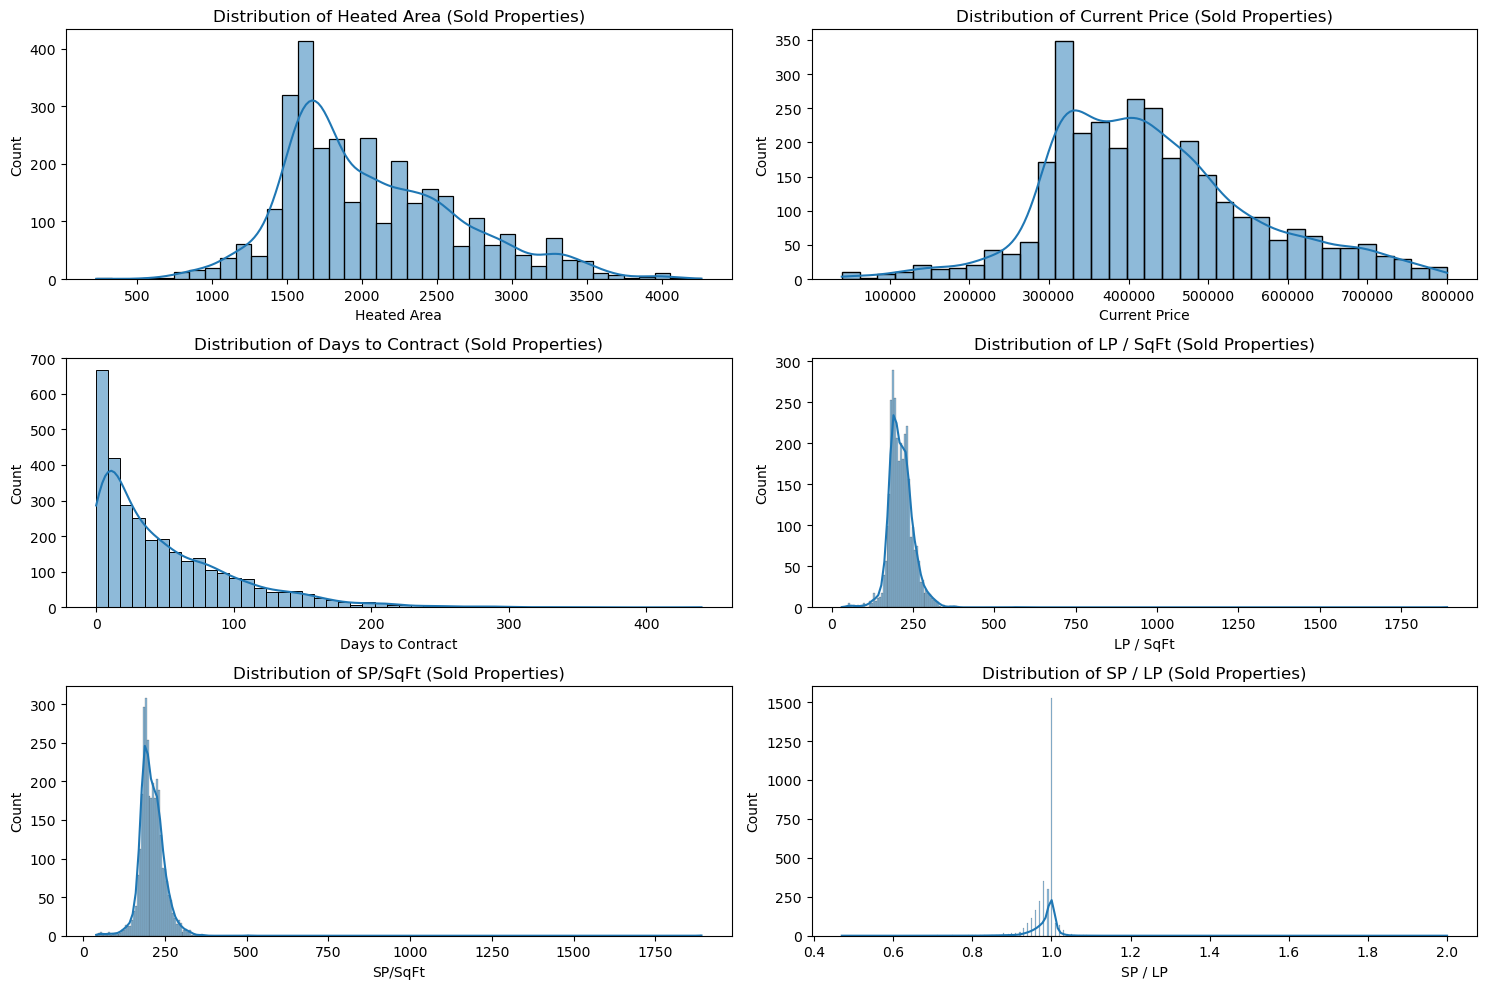

In [35]:
# Histegram for numeric variables
numeric_cols = ['Heated Area', 'Current Price', 'Days to Contract', 'LP / SqFt', 'SP/SqFt', 'SP / LP']
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    sns.histplot(sld_data[col].dropna(), kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Distribution of {col} (Sold Properties)')
    
plt.tight_layout()
plt.show()

Interpretation:
- Heated Area:  The majority of properties have heated areas between 1,000 and 2,500 sq ft, with a peak around 1,500–2,000 sq ft.
  
- Current Price: There’s a peak around $300,000–$400,000, which indicates the average price range. Prices drop off quickly beyond $700,000, showing fewer higher-priced properties.
  
- Days to Contract: Many properties are contracted within 0–50 days, with a long tail extending to over 300 days.
  
- SP/SqFt : The distribution closely mirrors the list price distribution, centered around $200–$300 per sq ft.
- LP/SqFt: The majority of properties are listed between $150 and $300 per sq ft, with some outliers exceeding $750.
- SP / LP : Most properties have a SP/LP ratio near 1.0, meaning properties are selling close to their list prices. There are a few cases where the ratio is significantly above or below 1.0.

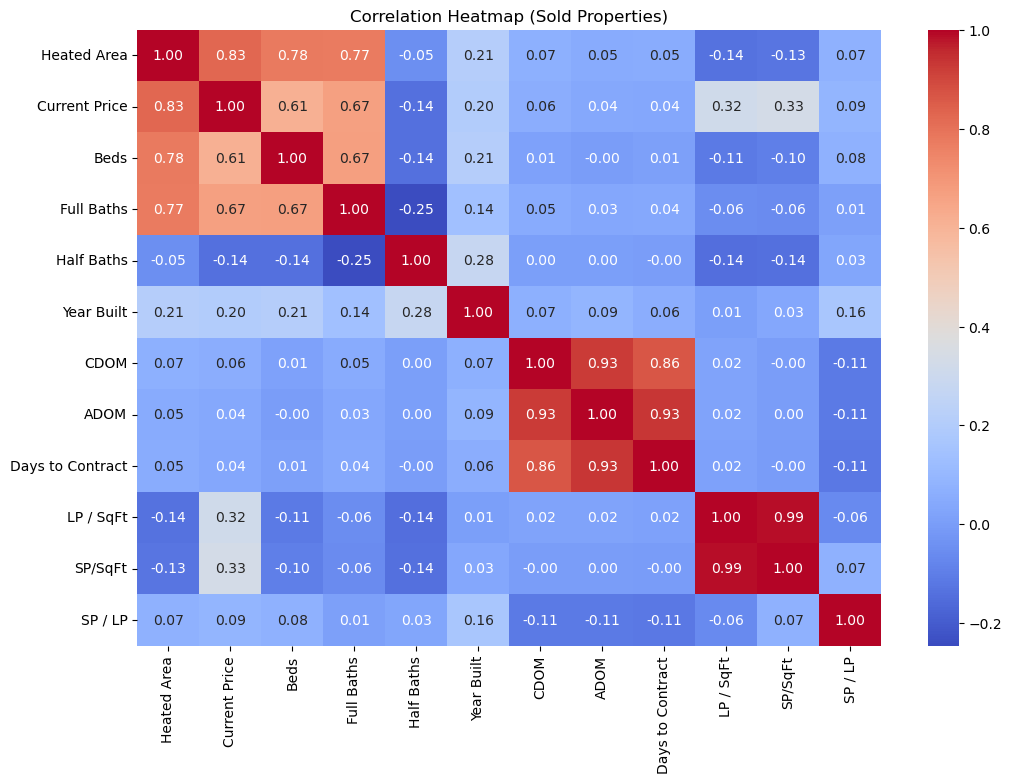

In [37]:
# Correlation Matrix
numeric_cols_sold = sld_data.select_dtypes(include=['float64', 'int64'])

correlation_matrix_sold = numeric_cols_sold.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_sold, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Sold Properties)')
plt.show()

Interpretation:
- Property size (measured by heated area) and price-related features are the most closely correlated variables.
- Days to contract and other market timing variables show weak correlations, implying that contract speed may depend on non-numeric features (e.g., property style, location).

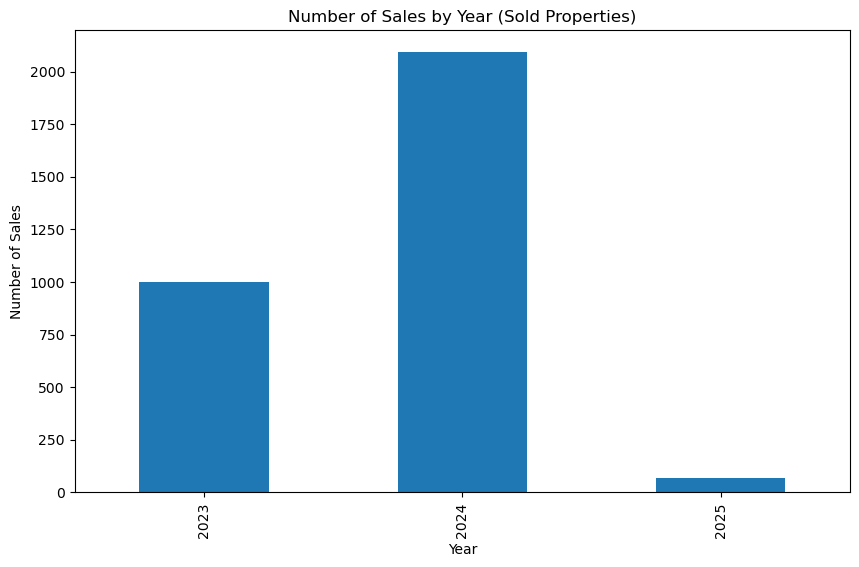

In [39]:
# Plot number of sales by Year

sales_by_year_sold = sld_data['Close Year'].value_counts().sort_index()
sales_by_year_sold.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Sales by Year (Sold Properties)')
plt.xlabel('Year')
plt.ylabel('Number of Sales')
plt.show()

Interpretation:
Sales peaked in 2024, with significantly fewer transactions in 2023 

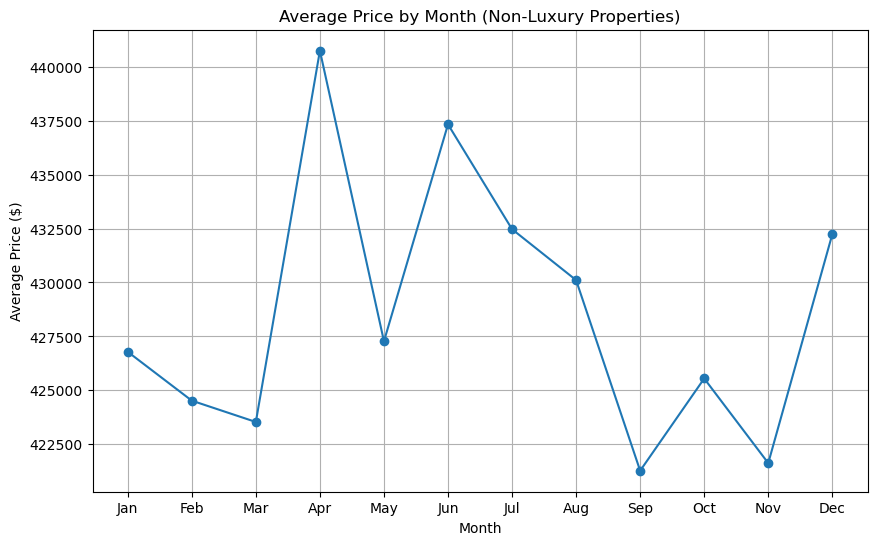

In [41]:
# Plot average price by month
monthly_non_lux = sld_data.groupby('Close Month').agg(
    Avg_Price=('Current Price', 'mean'),
    Sales_Count=('Current Price', 'count')
).sort_index()


plt.figure(figsize=(10, 6))
plt.plot(monthly_non_lux.index, monthly_non_lux['Avg_Price'], marker='o')
plt.title('Average Price by Month (Non-Luxury Properties)')
plt.xlabel('Month')
plt.ylabel('Average Price ($)')
plt.grid(True)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

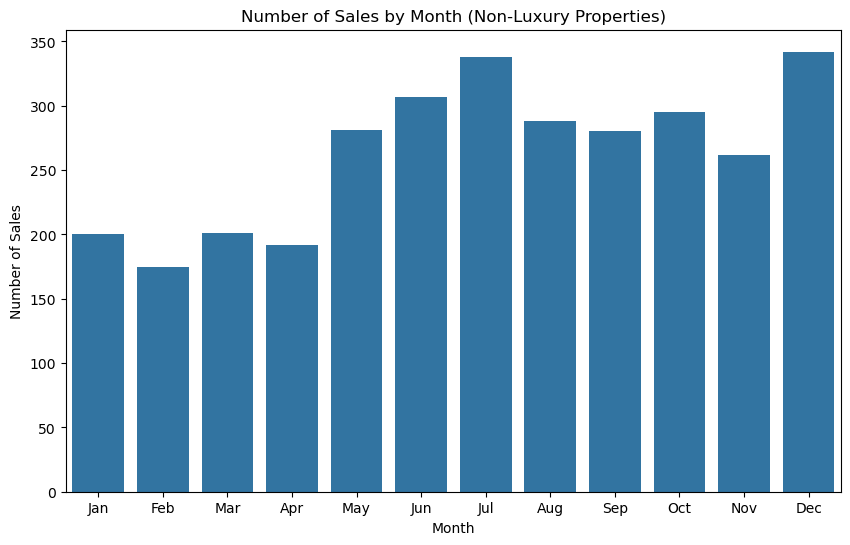

In [42]:
# Plot the number of sales by month
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_non_lux.index, y=monthly_non_lux['Sales_Count'])
plt.title('Number of Sales by Month (Non-Luxury Properties)')
plt.xlabel('Month')
plt.ylabel('Number of Sales')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

Interpretation:
- The highest average price appears in April (Month 4) and June (Month 6), both exceeding $440,000. Also, there is a significant drop in average price around September (Month 9).
- After a low point around September and October, prices begin to rise again in November and December.

In [44]:
# Detect outliers for 'Current Price' in sold properties
price_outliers_sold = detect_outliers(sld_data, 'Current Price')
print(price_outliers_sold['Current Price'].describe())

count        61.000000
mean     640009.754098
std      278023.564108
min       40000.000000
25%      749900.000000
50%      760000.000000
75%      780000.000000
max      799900.000000
Name: Current Price, dtype: float64


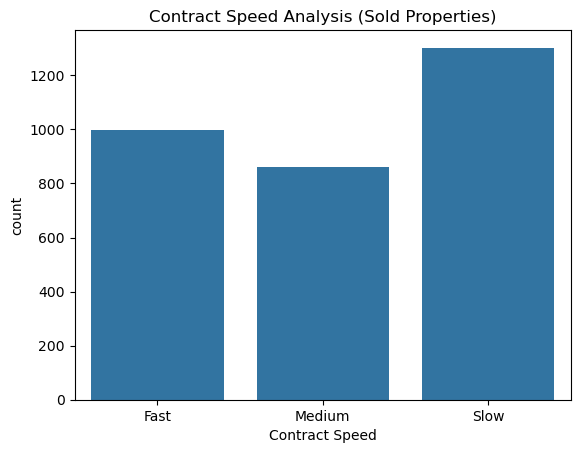

In [45]:
# Contract Speed analysis for Sold Data
sns.countplot(x='Contract Speed', data=sld_data, order=['Fast', 'Medium', 'Slow'])
plt.title('Contract Speed Analysis (Sold Properties)')
plt.show()

Interpretation: 
- The largest number of properties fall under the Slow category, indicating that a significant portion of properties take a long time to go under contract.
- This is followed by properties with Fast contract speeds, while the Medium speed category has the fewest properties.
- Fast vs. Slow: While Fast contracts are still common, properties tend to either move very quickly or get stuck on the market for an extended period.

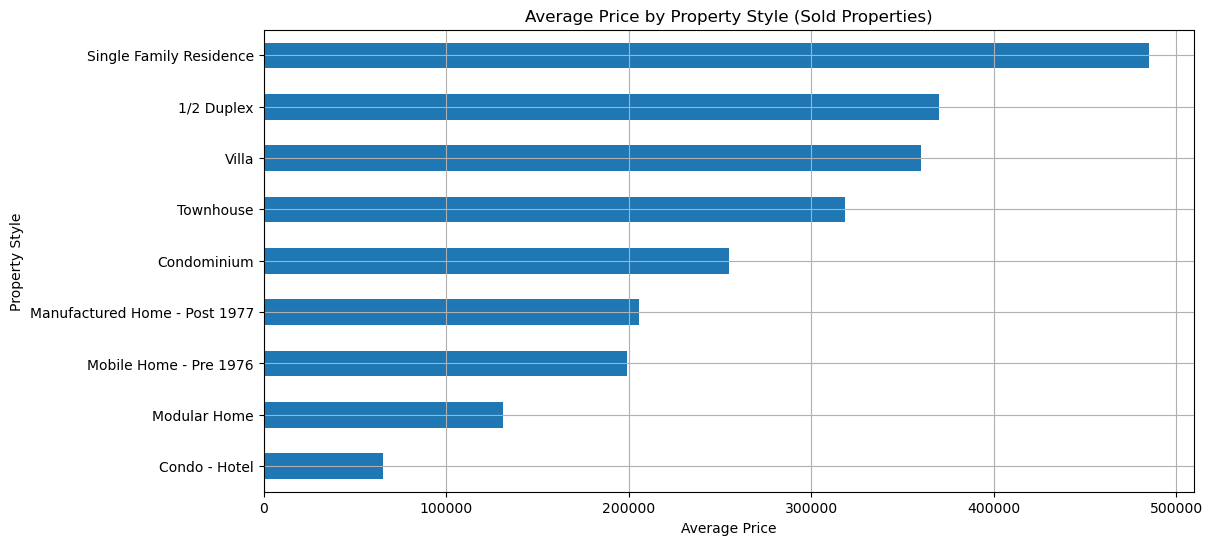

In [47]:
# Average price by property style
avg_price_by_style = sld_data.groupby('Property Style')['Current Price'].mean().sort_values()

# Visualize 
avg_price_by_style.plot(kind='barh', figsize=(12, 6))
plt.title('Average Price by Property Style (Sold Properties)')
plt.xlabel('Average Price')
plt.ylabel('Property Style')
plt.grid()
plt.show()

Interpretation:
- Properties classified as "Single Family Residence" tend to have the highest average price, while styles like "Condo-Hotel" and "Modular Home" are among the least expensive.

- The property style can significantly influence pricing, with more desirable or spacious styles fetching higher prices.

In [49]:
# Compare contract speed for luxury vs non-luxury properties
lux_speed_counts = lux_data['Contract Speed'].value_counts()
non_lux_speed_counts = sld_data['Contract Speed'].value_counts()

print(f'Luxury Contract Speed:\n{lux_speed_counts}')
print(f'Non-Luxury Contract Speed:\n{non_lux_speed_counts}')

Luxury Contract Speed:
Contract Speed
Slow      65
Fast      60
Medium    42
Name: count, dtype: int64
Non-Luxury Contract Speed:
Contract Speed
Slow      1302
Fast       998
Medium     861
Name: count, dtype: int64


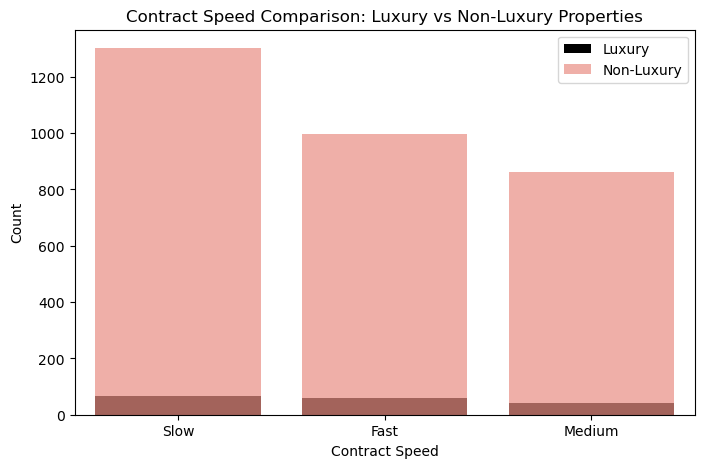

In [50]:
# Plot contract speed comparison
plt.figure(figsize=(8, 5))

sns.barplot(x=lux_speed_counts.index, y=lux_speed_counts.values, color='black', label='Luxury')
sns.barplot(x=non_lux_speed_counts.index, y=non_lux_speed_counts.values, color='salmon', alpha=0.7, label='Non-Luxury')

plt.title('Contract Speed Comparison: Luxury vs Non-Luxury Properties')
plt.xlabel('Contract Speed')
plt.ylabel('Count')
plt.legend()
plt.show()

Interpretation:
- Both Luxury and Non-Luxury properties have a higher count of slow contracts, indicating that long contract durations are a general trend across property types.
- Fast contracts are the second most common, followed by medium-speed contracts.
- Even though luxury properties are fewer in number, they follow a similar pattern of contract speed, suggesting similar market trends between luxury and non-luxury properties.

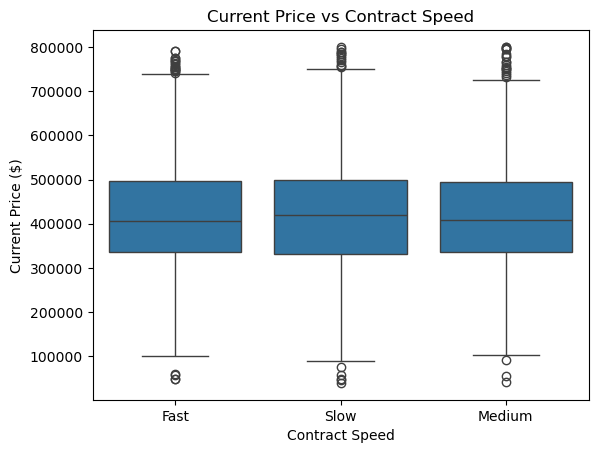

In [52]:
# Boxplot for current Price vs Contract Speed
sns.boxplot(x='Contract Speed', y='Current Price', data=sld_data)
plt.title('Current Price vs Contract Speed')
plt.ylabel('Current Price ($)')
plt.xlabel('Contract Speed')
plt.show()

Interpretation:
- The similarity in median prices and the overlap of interquartile ranges (boxes) across contract speed categories suggests that price does not significantly influence contract speed.  This implies other factors (e.g., location, property condition, marketing) likely play a more important role in determining how fast a property goes under contract.
- Outliers, particularly in the high price range, may indicate properties that sold slowly due to their unique characteristics or pricing strategy.

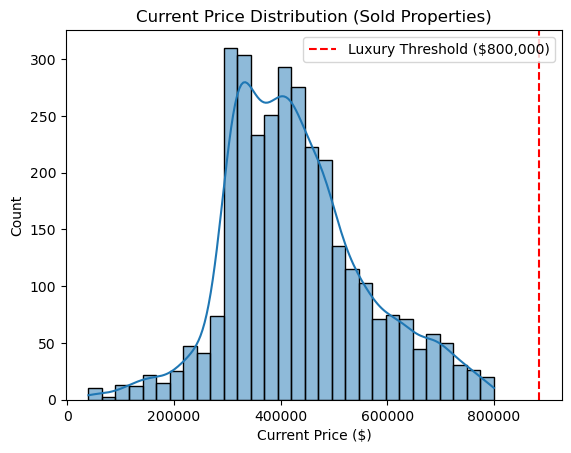

In [54]:
# Plot histogram to visualize price distribution

sns.histplot(sld_data['Current Price'], bins=30, kde=True)
plt.axvline(885000, color='red', linestyle='--', label='Luxury Threshold ($800,000)')
plt.title('Current Price Distribution (Sold Properties)')
plt.xlabel('Current Price ($)')
plt.ylabel('Count')
plt.legend()
plt.show()

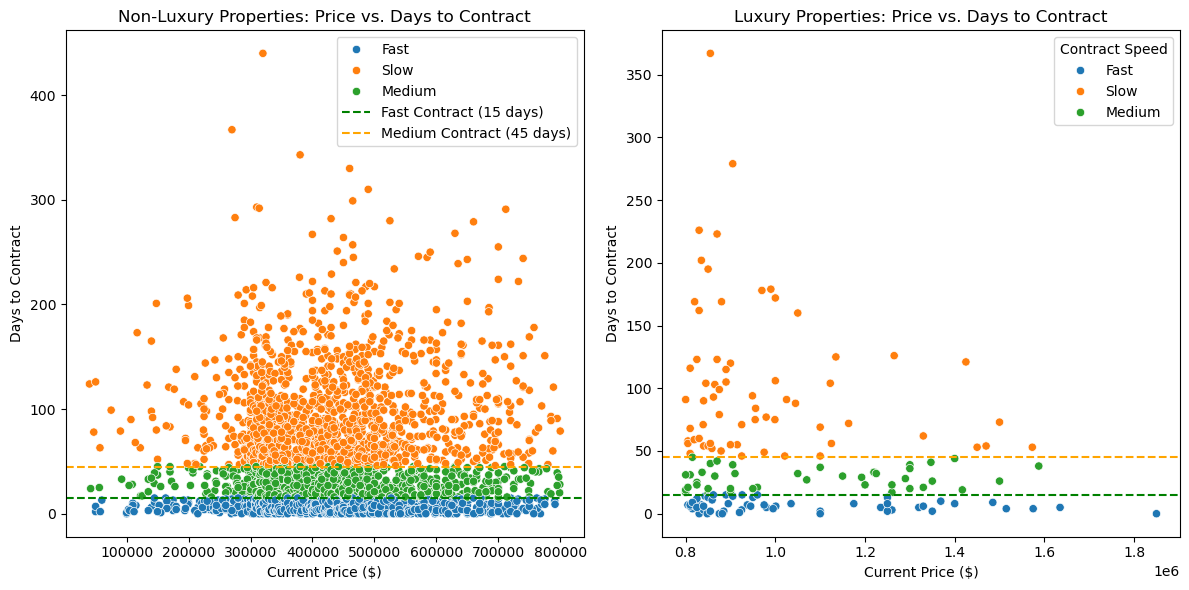

In [55]:
# Separate plots for luxury and non-luxury properties
plt.figure(figsize=(12, 6))

# Non-luxury properties
plt.subplot(1, 2, 1)
sns.scatterplot(x='Current Price', y='Days to Contract', hue='Contract Speed', data=sld_data)
plt.title('Non-Luxury Properties: Price vs. Days to Contract')
plt.xlabel('Current Price ($)')
plt.ylabel('Days to Contract')
plt.axhline(y=15, color='green', linestyle='--', label='Fast Contract (15 days)')
plt.axhline(y=45, color='orange', linestyle='--', label='Medium Contract (45 days)')
plt.legend()

# Luxury properties
plt.subplot(1, 2, 2)
sns.scatterplot(x='Current Price', y='Days to Contract', hue='Contract Speed', data=lux_data)
plt.title('Luxury Properties: Price vs. Days to Contract')
plt.xlabel('Current Price ($)')
plt.ylabel('Days to Contract')
plt.axhline(y=15, color='green', linestyle='--')
plt.axhline(y=45, color='orange', linestyle='--')

plt.tight_layout()
plt.show()


Interpretation:
- Non-Luxury Properties tend to sell quickly if priced between $200,000 and $500,000, suggesting this is an optimal price range for fast contracts.
- Luxury Properties experience slower contracts more frequently, particularly as prices rise above $1.2 million. Competitive pricing in the lower luxury range may facilitate faster sales.
- Outliers with both extremely high prices and long days to contract may represent properties that are overpriced or have unique features that reduce demand.

In [57]:
# Summary for non-luxury properties
non_lux_summary = sld_data.groupby('Contract Speed')['Current Price'].describe()
print("Non-Luxury Properties Contract Speed Summary:\n", non_lux_summary)

# Summary for luxury properties
lux_summary = lux_data.groupby('Contract Speed')['Current Price'].describe()
print("Luxury Properties Contract Speed Summary:\n", lux_summary)

Non-Luxury Properties Contract Speed Summary:
                  count           mean            std      min        25%  \
Contract Speed                                                             
Fast             998.0  425472.606212  132015.685842  49999.0  335695.25   
Medium           861.0  428789.376307  128960.084505  42000.0  337000.00   
Slow            1302.0  431449.597542  126800.861102  40000.0  332000.00   

                     50%       75%       max  
Contract Speed                                
Fast            406995.0  496750.0  791520.0  
Medium          408000.0  495000.0  799236.0  
Slow            419990.0  499990.0  799900.0  
Luxury Properties Contract Speed Summary:
                 count          mean            std       min        25%  \
Contract Speed                                                            
Fast             60.0  1.023221e+06  249649.306007  805000.0  842547.75   
Medium           42.0  1.076197e+06  234230.774147  800000.0  851250.

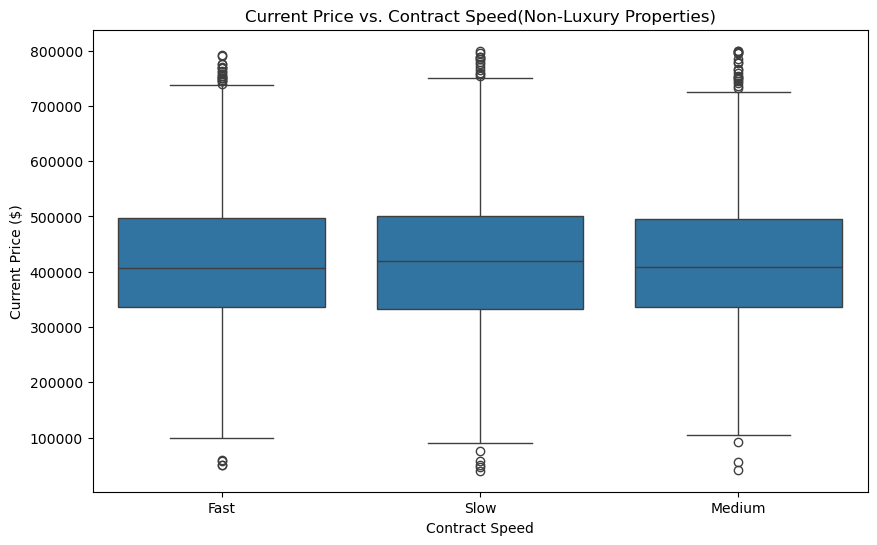

In [58]:
# Boxplot: Current Price vs. Contract Speed for non-Luxury
plt.figure(figsize=(10, 6))
sns.boxplot(x='Contract Speed', y='Current Price', data=sld_data)
plt.title('Current Price vs. Contract Speed(Non-Luxury Properties)')
plt.ylabel('Current Price ($)')
plt.show()

Interpretation:
- Price does not appear to be a strong differentiating factor for contract speed within non-luxury properties, as evidenced by similar medians and overlapping IQRs.
- There might be other factors (e.g., property condition, marketing efforts, or location) influencing how quickly a property sells in this segment.

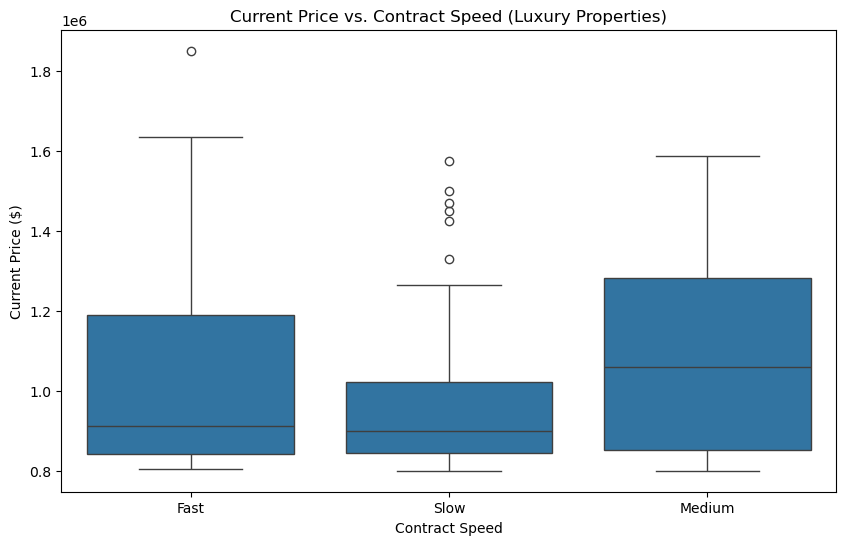

In [60]:
# Boxplot: Current Price vs. Contract Speed for Luxury
plt.figure(figsize=(10, 6))
sns.boxplot(x='Contract Speed', y='Current Price', data=lux_data)
plt.title('Current Price vs. Contract Speed (Luxury Properties)')
plt.ylabel('Current Price ($)')
plt.show()

Interpretation:
- Luxury properties priced closer to $900,000 tend to sell faster, while those above $1.2 million take longer to find buyers.
- The price difference between Medium and Slow contracts is less significant than between Fast and Slow contracts, reinforcing the importance of pricing closer to the lower end of the luxury segment for quicker sales.

                                   Avg_Price  Sales_Count
Property Style                                           
Single Family Residence        485292.965613         2152
1/2 Duplex                     370000.000000            1
Villa                          360020.703911          179
Townhouse                      318576.664706          680
Condominium                    255153.846154           13
Manufactured Home - Post 1977  205713.675214          117
Mobile Home - Pre 1976         199198.714286            7
Modular Home                   131000.000000            3
Condo - Hotel                   65277.666667            9


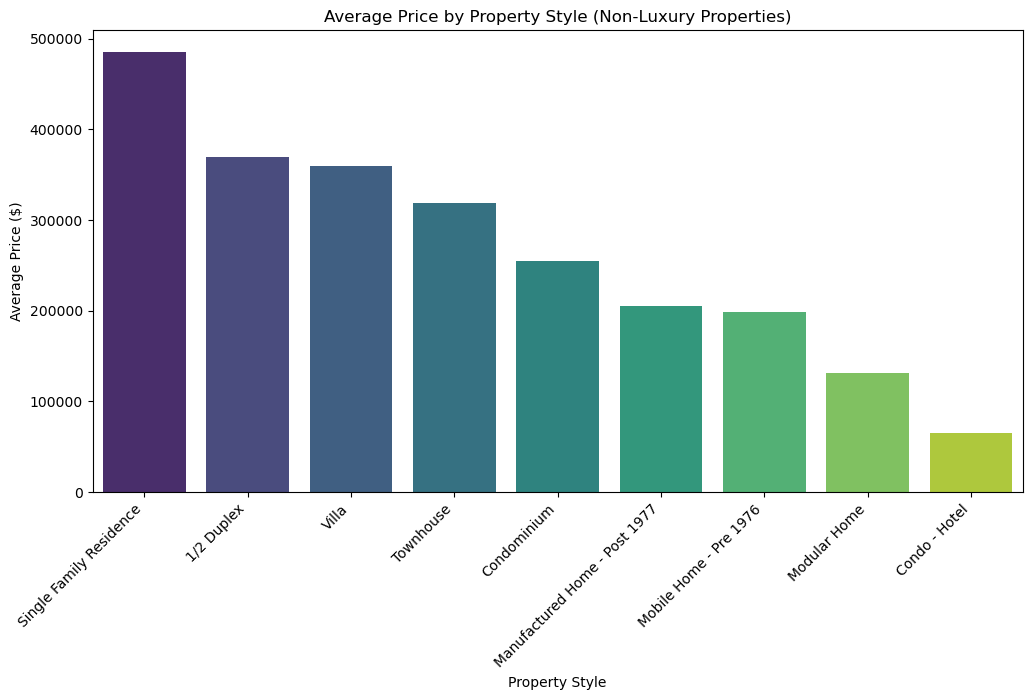

In [62]:
# Group by property style to calculate average price
style_price_data = sld_data.groupby('Property Style').agg(
    Avg_Price=('Current Price', 'mean'),
    Sales_Count=('Current Price', 'count')
).sort_values(by='Avg_Price', ascending=False)

# Display summary data
print(style_price_data)

# Plot the average price by property style
plt.figure(figsize=(12, 6))
sns.barplot(x=style_price_data.index, y=style_price_data['Avg_Price'], hue=style_price_data.index, dodge=False, palette='viridis')
plt.title('Average Price by Property Style (Non-Luxury Properties)')
plt.xlabel('Property Style')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45, ha='right')
plt.legend([], [], frameon=False)  # Disable the legend
plt.show()

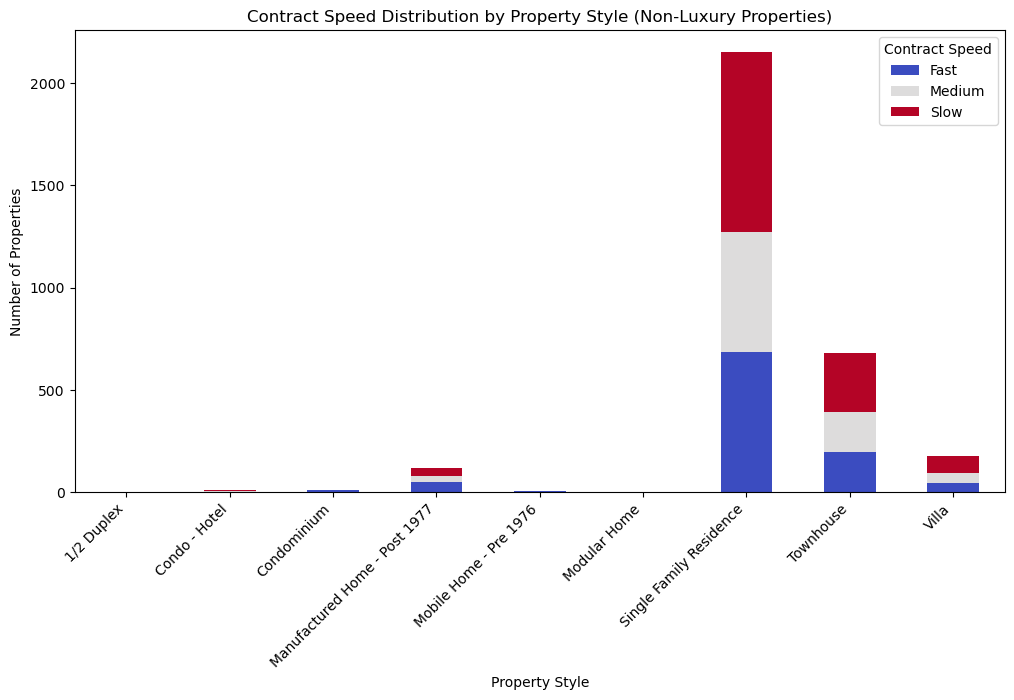

In [63]:
# Group by property style and contract speed
style_speed_counts = sld_data.groupby(['Property Style', 'Contract Speed']).size().unstack().fillna(0)

# Plot a grouped bar chart for contract speed by property style
style_speed_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
plt.title('Contract Speed Distribution by Property Style (Non-Luxury Properties)')
plt.xlabel('Property Style')
plt.ylabel('Number of Properties')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Contract Speed')
plt.show()


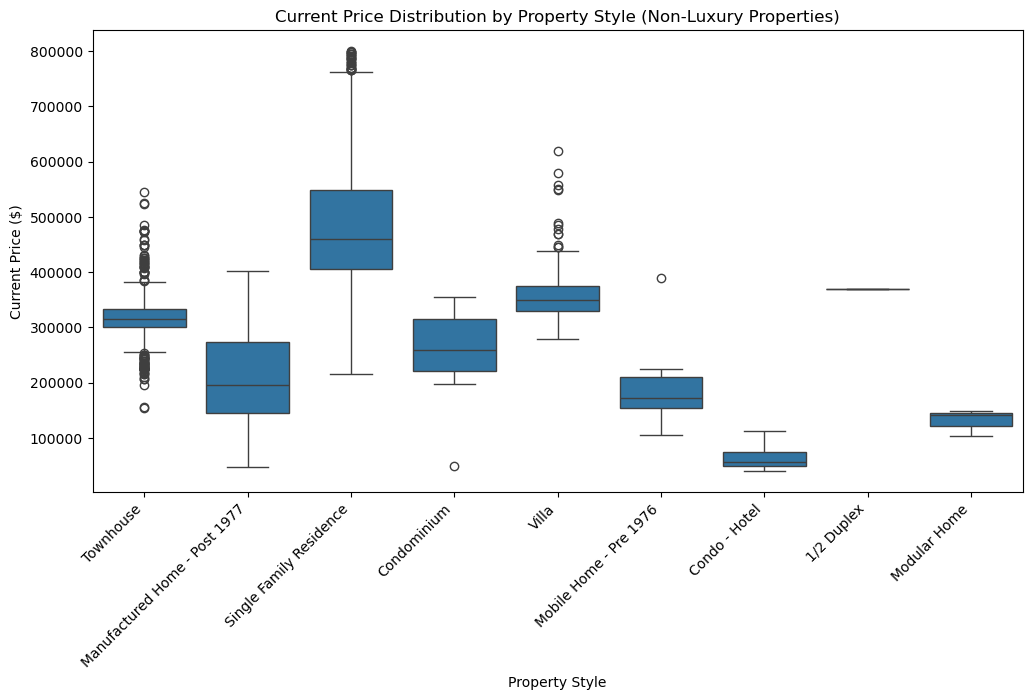

In [64]:
# Boxplot for price distribution by property style
plt.figure(figsize=(12, 6))
sns.boxplot(x='Property Style', y='Current Price', data=sld_data)
plt.title('Current Price Distribution by Property Style (Non-Luxury Properties)')
plt.xlabel('Property Style')
plt.ylabel('Current Price ($)')
plt.xticks(rotation=45, ha='right')
plt.show()

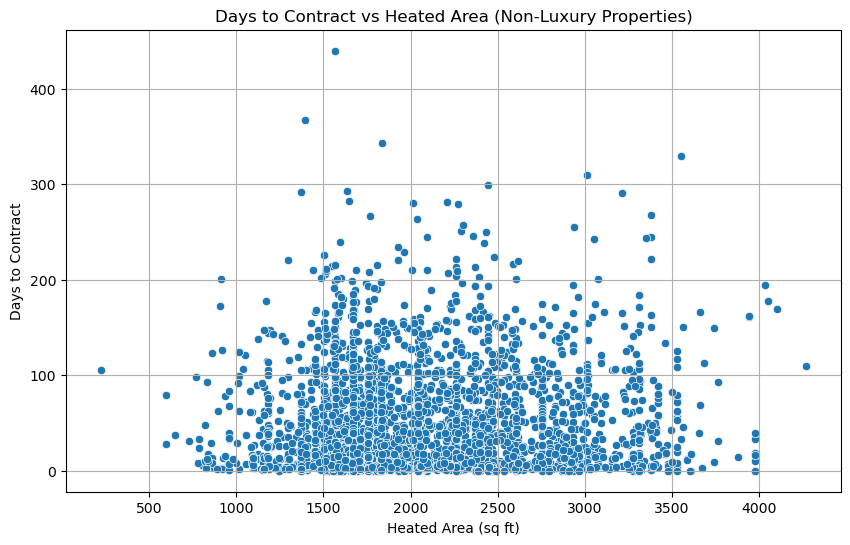

In [65]:
#Scatter Plot: Heated Area vs. Days to Contract
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Heated Area', y='Days to Contract', data=sld_data)
plt.title('Days to Contract vs Heated Area (Non-Luxury Properties)')
plt.xlabel('Heated Area (sq ft)')
plt.ylabel('Days to Contract')
plt.grid(True)
plt.show()

Interpretation:
- There is no strong linear relationship between heated area and days to contract, indicating that other factors, such as pricing, location, or market demand, might have more influence on time-to-contract.

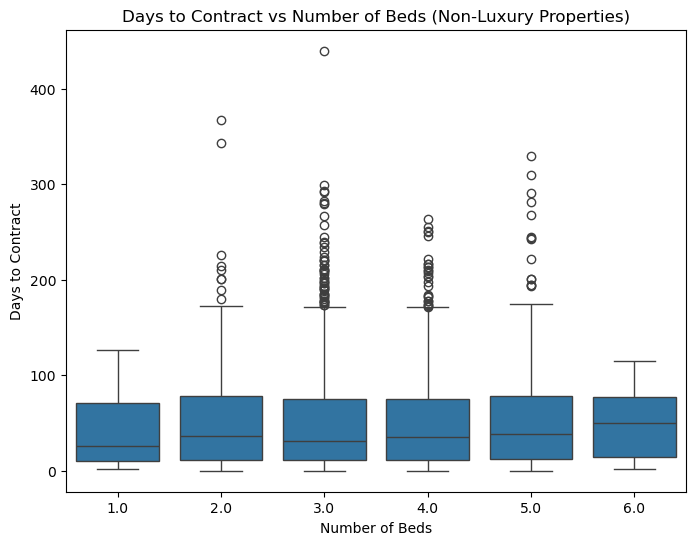

In [67]:
#Boxplot: Beds vs. Days to Contract
plt.figure(figsize=(8, 6))
sns.boxplot(x='Beds', y='Days to Contract', data=sld_data)
plt.title('Days to Contract vs Number of Beds (Non-Luxury Properties)')
plt.xlabel('Number of Beds')
plt.ylabel('Days to Contract')
plt.show()

Interpretation:
- Properties with 1 to 5 bedrooms show similar median days to contract. This suggests that the number of bedrooms does not strongly influence the speed of contract closure in non-luxury properties.

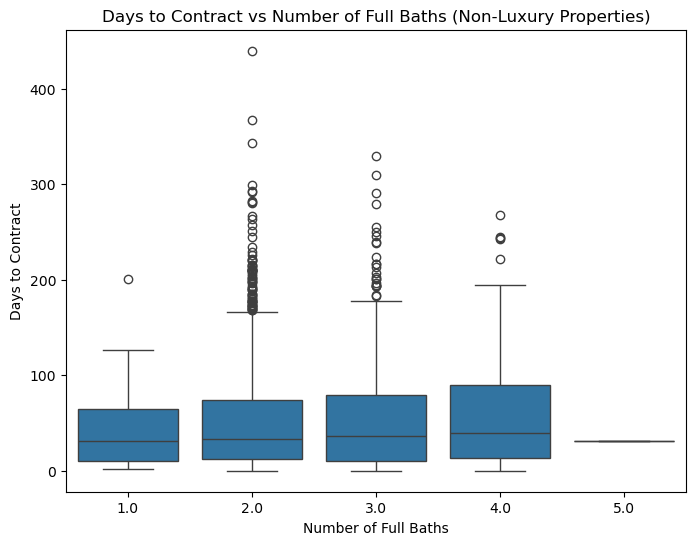

In [69]:
#Boxplot: Full Baths vs. Days to Contract
plt.figure(figsize=(8, 6))
sns.boxplot(x='Full Baths', y='Days to Contract', data=sld_data)
plt.title('Days to Contract vs Number of Full Baths (Non-Luxury Properties)')
plt.xlabel('Number of Full Baths')
plt.ylabel('Days to Contract')
plt.show()

Interpretation:
- Properties with 1 to 4 full baths have similar median days to contract, indicating that the number of full bathrooms does not strongly affect how quickly properties go under contract.
- There are very few or no significant data points for properties with more than 4 full baths, indicating that they may be rare in the dataset for non-luxury properties.

In [71]:
# Calculate correlation between Days to Contract and other continuous features
correlations = sld_data[['Days to Contract', 'Heated Area', 'Current Price', 'Beds', 'Full Baths', 'Half Baths']].corr()
print("Correlation with Days to Contract:\n", correlations['Days to Contract'])

Correlation with Days to Contract:
 Days to Contract    1.000000
Heated Area         0.053663
Current Price       0.035950
Beds                0.009647
Full Baths          0.040209
Half Baths         -0.000974
Name: Days to Contract, dtype: float64


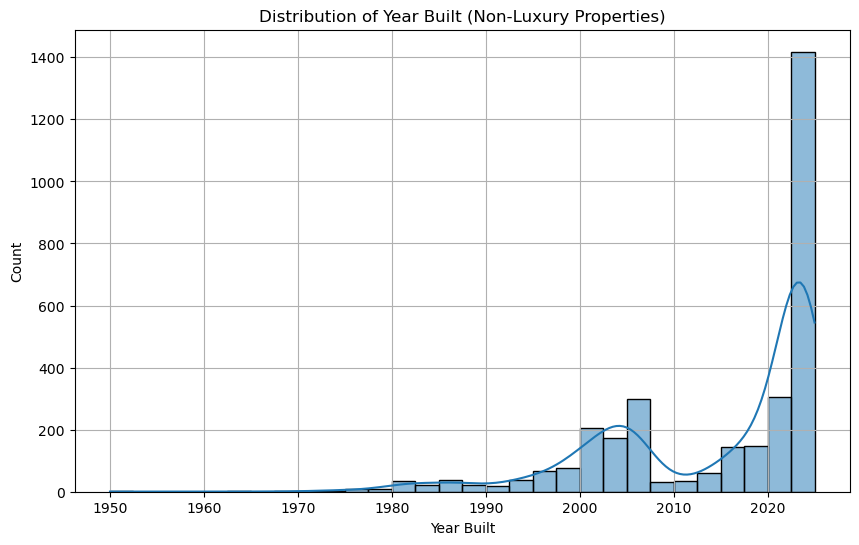

In [72]:
#Analysis of Year Built
#Histogram of year built
plt.figure(figsize=(10, 6))
sns.histplot(sld_data['Year Built'], bins=30, kde=True)
plt.title('Distribution of Year Built (Non-Luxury Properties)')
plt.xlabel('Year Built')
plt.ylabel('Count')
plt.grid()
plt.show()

Interpretation:
- From the 1980s onward, there has been a gradual rise in the number of properties built, with growth accelerating significantly in the last two decades.
- The data may reflect market trends favoring newer construction, which could be linked to buyer preferences for modern designs, amenities, or energy-efficient features.

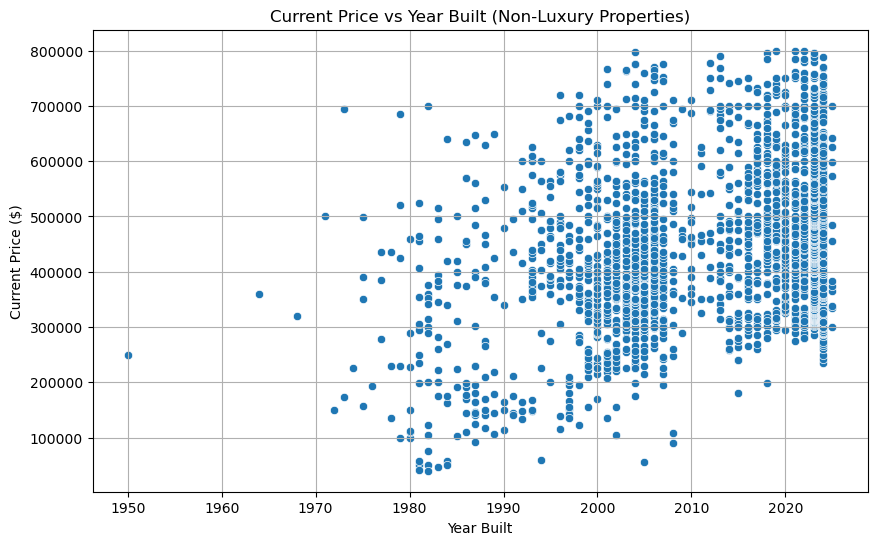

In [74]:
# Sctter plot for yeear Built vs Current Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year Built', y='Current Price', data=sld_data)
plt.title('Current Price vs Year Built (Non-Luxury Properties)')
plt.xlabel('Year Built')
plt.ylabel('Current Price ($)')
plt.grid()
plt.show()

Interpretation:
- There is a general upward trend indicating that newer properties tend to have higher prices. Properties built after 2000 show more data points in the higher price range, especially above $400,000.
- Properties built before 1980 have fewer data points in the upper price ranges, indicating a concentration of lower-priced properties. However, a few exceptions exist, potentially due to renovations or desirable locations.
- As observed in the previous chart, a large number of properties have been constructed since 2000, and these dominate the current real estate market data in both quantity and price distribution.

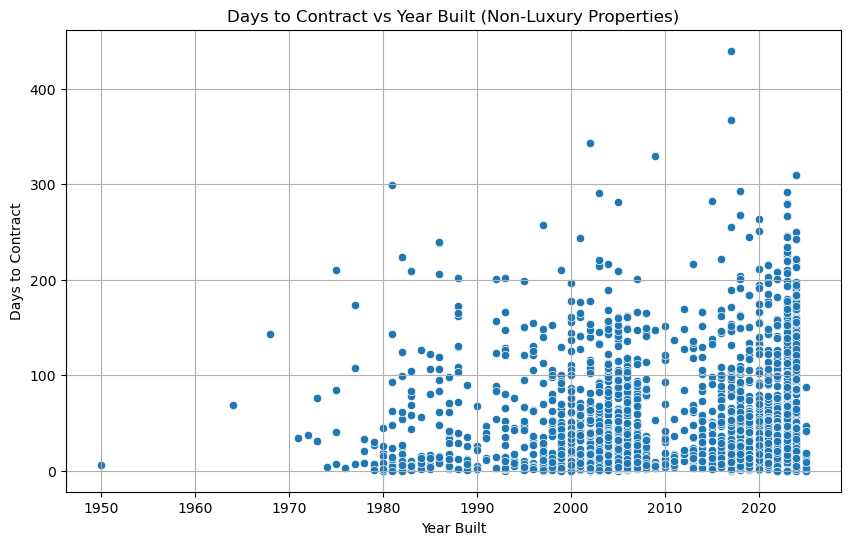

In [76]:
# Scatter plot for Year Built vs Days to Contract
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year Built', y='Days to Contract', data=sld_data)
plt.title('Days to Contract vs Year Built (Non-Luxury Properties)')
plt.xlabel('Year Built')
plt.ylabel('Days to Contract')
plt.grid()
plt.show()

Interpretation:
- Properties built after 2000 tend to have higher prices, especially those built in the 2010s.
- Overall the price Spread from all years show a wide range of prices, which might weaken the correlation.

In [78]:
# Group Analysis by Decade
sld_data['Decade'] = (sld_data['Year Built'] // 10) * 10

decade_analysis = sld_data.groupby('Decade').agg(
    Avg_Price=('Current Price', 'mean'),
    Avg_Days_to_Contract=('Days to Contract', 'mean'),
    Sales_Count=('Current Price', 'count')
).sort_index()
print('Decade Analysis:\n', decade_analysis)

Decade Analysis:
             Avg_Price  Avg_Days_to_Contract  Sales_Count
Decade                                                  
1950.0  250000.000000              6.000000            1
1960.0  340000.000000            106.000000            2
1970.0  342495.238095             45.190476           21
1980.0  295174.350427             51.264957          117
1990.0  400327.120000             41.855000          200
2000.0  410338.598870             45.598870          708
2010.0  490659.203608             54.126289          388
2020.0  436158.914153             53.010441         1724


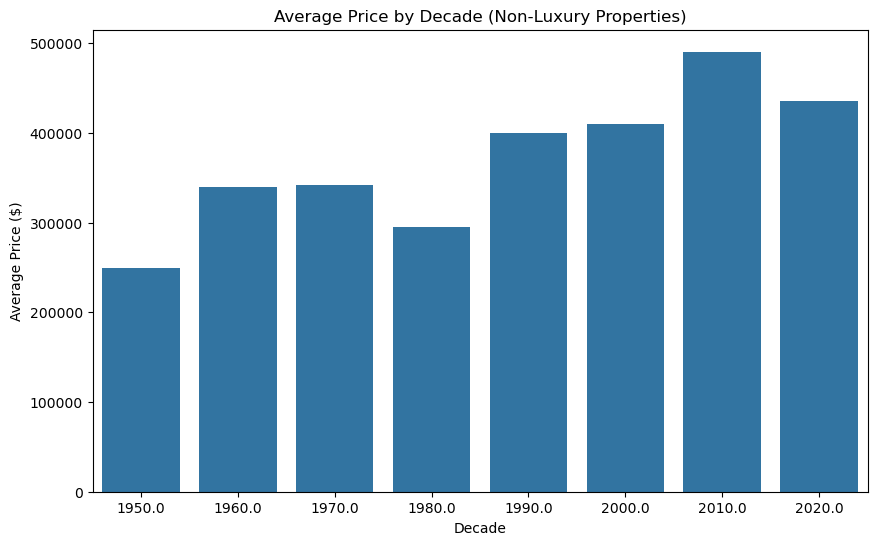

In [79]:
#Plot average price by decade
plt.figure(figsize=(10, 6))
sns.barplot(x=decade_analysis.index, y=decade_analysis['Avg_Price'])
plt.title('Average Price by Decade (Non-Luxury Properties)')
plt.xlabel('Decade')
plt.ylabel('Average Price ($)')
plt.show()

Interpretation:
- The 1960s to 2000s display relatively stable growth in average prices, without sharp changes. This may indicate consistent property value appreciation with few major market disruptions.
- Properties built in the 2010s show the highest average prices, possibly driven by modern amenities, better construction quality, and recent high demand for newer properties.

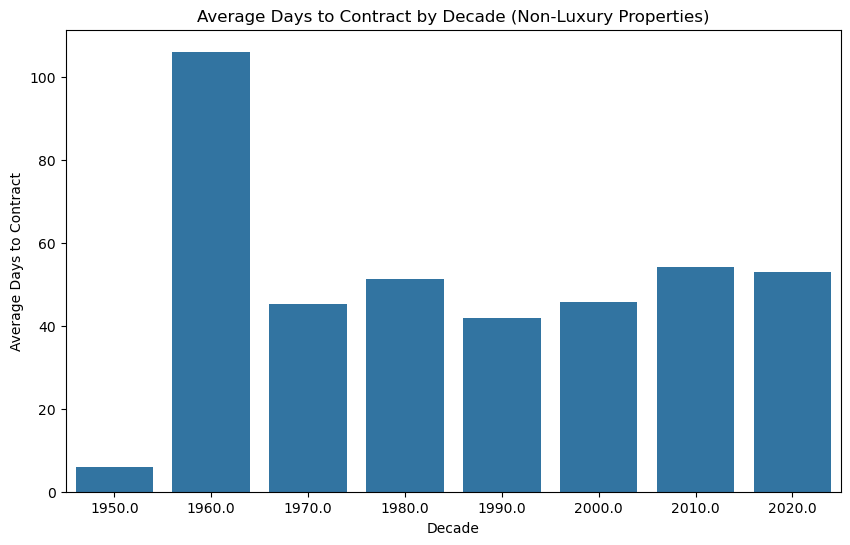

In [81]:
# Plot average days to contract by decade
plt.figure(figsize=(10, 6))
sns.barplot(x=decade_analysis.index, y=decade_analysis['Avg_Days_to_Contract'])
plt.title('Average Days to Contract by Decade (Non-Luxury Properties)')
plt.xlabel('Decade')
plt.ylabel('Average Days to Contract')
plt.show()

In [82]:
sld_data.groupby(['Decade', 'Property Style'])['Current Price'].mean().unstack()


Property Style,1/2 Duplex,Condo - Hotel,Condominium,Manufactured Home - Post 1977,Mobile Home - Pre 1976,Modular Home,Single Family Residence,Townhouse,Villa
Decade,,,,,,,,,
1950.0,NaN,NaN,NaN,NaN,NaN,NaN,250000.000000,NaN,NaN
1960.0,NaN,NaN,NaN,NaN,NaN,NaN,340000.000000,NaN,NaN
1970.0,NaN,NaN,NaN,173725.000000,214916.666667,NaN,473454.545455,NaN,NaN
1980.0,NaN,65277.666667,250166.666667,180948.888889,NaN,103000.0,454085.714286,NaN,450000.000000
1990.0,NaN,NaN,NaN,198905.405405,NaN,145000.0,468479.074830,229136.363636,343000.000000
2000.0,NaN,NaN,315000.000000,242836.363636,104891.000000,NaN,449614.175047,262763.372093,339622.540984
2010.0,NaN,NaN,NaN,275333.333333,NaN,NaN,535436.056856,325664.920635,405575.000000
2020.0,370000.0,NaN,NaN,292333.333333,NaN,NaN,493270.926763,328840.561538,363151.393617


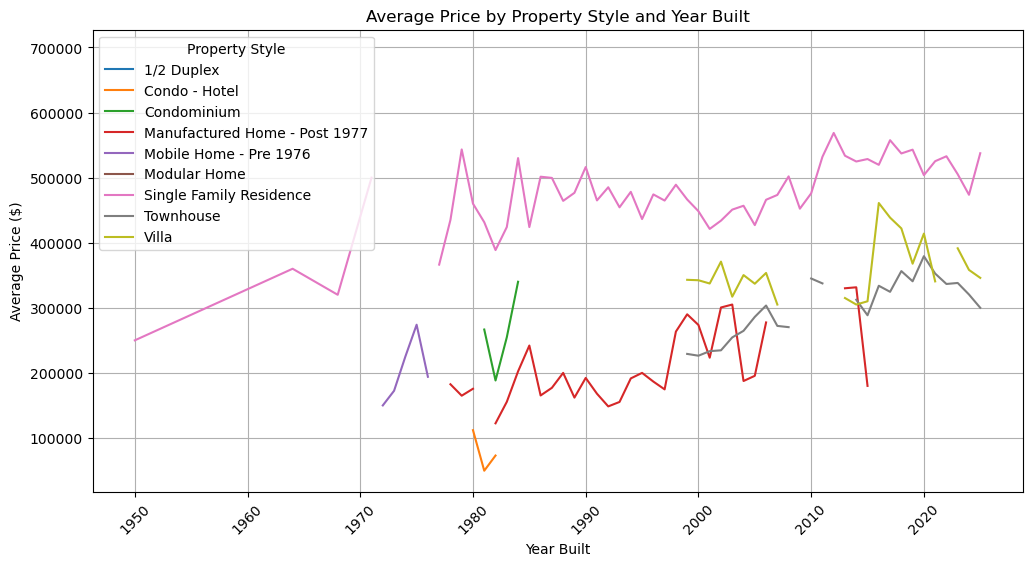

In [83]:
# Analyze Prices by Property Style and Year Built
style_year_analysis = sld_data.groupby(['Year Built', 'Property Style'])['Current Price'].mean().unstack()
style_year_analysis.plot(figsize=(12, 6), title='Average Price by Property Style and Year Built')
plt.xlabel('Year Built')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

Interpretation:
- Single Family Residences show relatively stable price increases over time and currently hold some of the highest average prices.
- Townhouses and Villas display price fluctuations, especially for properties built after 2000, suggesting more variability in these markets.
- Mobile and Manufactured Homes have consistently lower prices across years.
- Properties built after 2000 reflect higher prices across styles, correlating with more modern designs and newer amenities.


In [85]:
#Compare Subdivisions (Neighborhoods)
subdivision_analysis = sld_data.groupby(['Legal Subdivision Name', 'Year Built']).agg(
    Avg_Price=('Current Price', 'mean'),
    Count=('Current Price', 'count')
).sort_values(by='Avg_Price', ascending=False)

print(subdivision_analysis.head(10))


                                              Avg_Price  Count
Legal Subdivision Name            Year Built                  
WATERGRASS PCLS B5 & B6           2022.0       799900.0      1
WHISPERING OAKS                   2021.0       798940.0      1
EPPERSON RANCH SOUTH PH 1 B-2     2018.0       795000.0      1
ESTANCIA PH 2B1                   2022.0       785000.0      1
EPPERSON RANCH SOUTH PH 2H-2      2021.0       785000.0      1
MEADOW POINTE IV PRCL N-P ENCLAVE 2018.0       784900.0      1
WINDING RDG PH 1 & 2              2023.0       780000.0      1
ESPLANADE/WIREGRASS RANCH PH I    2022.0       780000.0      1
SEVEN OAKS PRCL C-1C/C-1D         2012.0       777999.0      1
WESTWOOD ESTATES                  2004.0       775000.0      1


In [86]:
high_count_subdivisions = subdivision_analysis[subdivision_analysis['Count'] > 1]
print(high_count_subdivisions.head(20))

                                                       Avg_Price  Count
Legal Subdivision Name                 Year Built                      
SEVEN OAKS PARCELS S-13A & S-13B       2004.0      768750.000000      2
EPPERSON NORTH VILLAGE                 2023.0      745995.000000      2
WHISPERING OAKS PRESERVE PHASE 2 AND 3 2024.0      737205.000000      2
ESTANCIA PH 1D                         2015.0      722500.000000      2
ESPLANADE/WIREGRASS RANCH PHS          2024.0      714450.000000      2
THE RIDGE AT WIREGRASS RANCH           2018.0      706666.666667      3
COUNTRY WALK INCREMENT E PH 02         2007.0      706666.666667      3
THE RIDGE AT WIREGRASS RANCH           2016.0      701250.000000      2
WINDING RIDGE                          2023.0      701177.400000      5
WINDING RIDGE PH 1 & 2                 2022.0      697500.000000      2
RIVER LANDING                          2023.0      696679.857143      7
SEVEN OAKS PRCL S-9                    2006.0      693500.000000

In [87]:
print("Unique Subdivisions:", sld_data['Legal Subdivision Name'].nunique())
print("Subdivision Value Counts:\n", sld_data['Legal Subdivision Name'].value_counts())

Unique Subdivisions: 600
Subdivision Value Counts:
 Legal Subdivision Name
EPPERSON RANCH                 263
WESTGATE AT AVALON PARK        245
PASADENA POINT                  92
WOODCREEK                       78
UNION PARK                      77
                              ... 
WIREGRASS                        1
AVALON PARK WEST PH 3            1
MEADOW POINTE 3 PRCL DD & Y      1
WESBRIDGE PH                     1
RIVER'S EDGE                     1
Name: count, Length: 600, dtype: int64


In [88]:
# Normalize subdivision names to ensure consistency
sld_data['Legal Subdivision Name'] = sld_data['Legal Subdivision Name'].str.strip().str.upper()

# Recheck unique subdivisions
normalized_subdivisions = sld_data['Legal Subdivision Name'].nunique()
print("Normalized Unique Subdivisions:", normalized_subdivisions)

Normalized Unique Subdivisions: 600


In [89]:
# Count properties per subdivision
subdivision_counts = sld_data['Legal Subdivision Name'].value_counts()

# Define threshold for major subdivisions (e.g., 10 properties)
threshold = 10
major_subdivisions = subdivision_counts[subdivision_counts > threshold].index

# Assign subdivisions with fewer properties to "Other Subdivisions"
sld_data['Subdivision Group'] = sld_data['Legal Subdivision Name'].apply(
    lambda x: x if x in major_subdivisions else 'Other Subdivisions'
)

In [90]:
# Group by the new subdivision grouping
subdivision_group_analysis = sld_data.groupby('Subdivision Group').agg(
    Avg_Price=('Current Price', 'mean'),
    Avg_Days_to_Contract=('Days to Contract', 'mean'),
    Sales_Count=('Current Price', 'count')
).sort_values(by='Sales_Count', ascending=False)

print("Subdivision Group Analysis:\n", subdivision_group_analysis)

Subdivision Group Analysis:
                                        Avg_Price  Avg_Days_to_Contract  \
Subdivision Group                                                        
Other Subdivisions                 457117.724982             48.742981   
EPPERSON RANCH                     461159.904943             60.228137   
WESTGATE AT AVALON PARK            391829.775510             45.510204   
PASADENA POINT                     429965.913043             44.728261   
WOODCREEK                          469562.282051             32.371795   
UNION PARK                         355705.779221             41.402597   
WATERGRASS TOWNS                   327227.260274             66.561644   
THE TOWNHOMES AT RIVER LANDING     309813.718310             39.422535   
TOWNS AT WOODSDALE                 320263.360656             67.950820   
MEADOW RIDGE                       325925.446429             56.535714   
ESPLANADE AT WIREGRASS RANCH       577496.500000             71.152174   
WESTGATE 

In [91]:
#Normalize Subdivision Names
def clean_subdivision_name(name):
    if pd.isna(name) or not isinstance(name, str):
        return name
    name = re.sub(r'\sPHASE?\s\d+[A-Z]*', '', name, flags=re.IGNORECASE)
    
    # Remove extra spaces and trailing numbers (e.g., "& 1C")
    name = re.sub(r'\s&?\s\d+[A-Z]*$', '', name)
    # Remove lot/block numbers (e.g., "LOT 5", "BLK 3")
    name = re.sub(r'\s+LOT\s+\d+|\s+BLK\s+\d+', '', name, flags=re.IGNORECASE)
    # Remove leading/trailing whitespace and make the name uppercase
    return name.strip().upper()

In [92]:
# Apply cleaning to the subdivision names
sld_data['Cleaned Subdivision'] = sld_data['Legal Subdivision Name'].apply(clean_subdivision_name)

# Check unique values after cleaning
print("Unique Subdivisions After Cleaning:", sld_data['Cleaned Subdivision'].nunique())
print(sld_data['Cleaned Subdivision'].value_counts().head(20))


Unique Subdivisions After Cleaning: 567
Cleaned Subdivision
EPPERSON RANCH                     263
WESTGATE AT AVALON PARK            245
PASADENA POINT                      93
WOODCREEK                           78
UNION PARK                          77
WATERGRASS TOWNS                    73
THE TOWNHOMES AT RIVER LANDING      71
TOWNS AT WOODSDALE                  61
MEADOW RIDGE                        56
ESPLANADE AT WIREGRASS RANCH        47
WESTGATE                            44
ANGUS VALLEY                        39
TIMBER LAKE ESTATES                 37
TWIN CREEKS AT CHAPEL CROSSINGS     33
SUMMERSTONE                         27
QUAIL HOLLOW PINES                  27
RIVER LANDING                       26
PERSIMMON PARK                      26
MEADOW POINTE                       25
CHAPEL CROSSINGS                    25
Name: count, dtype: int64


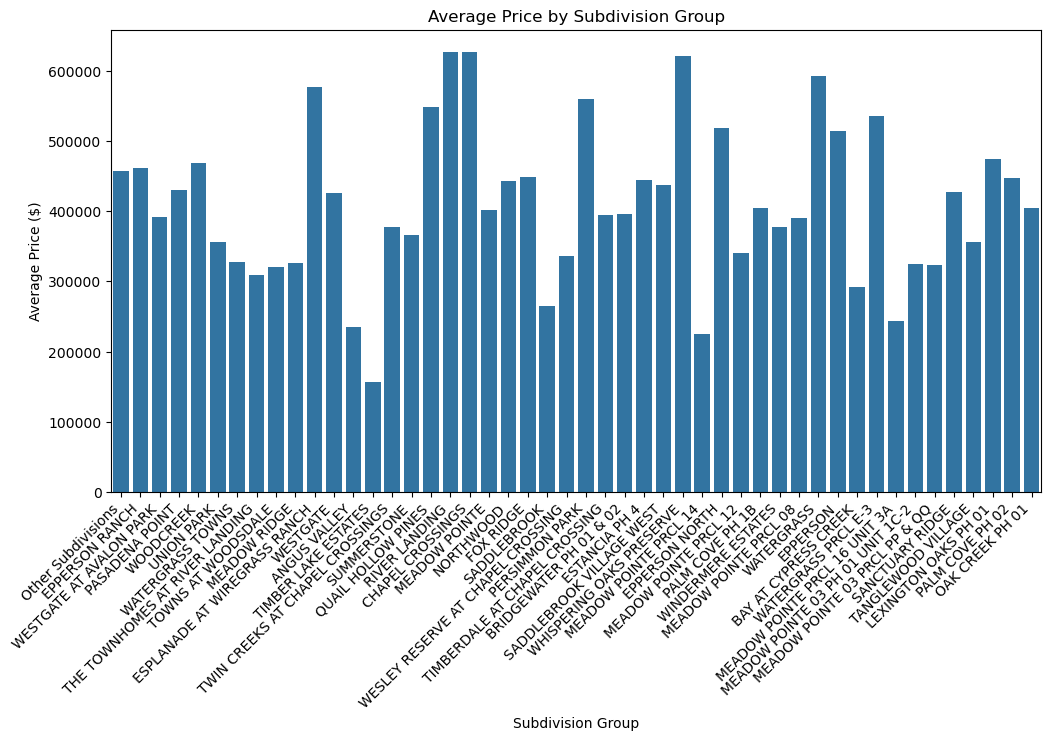

In [93]:
# Visualize average price by subdivision group
plt.figure(figsize=(12, 6))
sns.barplot(x=subdivision_group_analysis.index, y=subdivision_group_analysis['Avg_Price'])
plt.title('Average Price by Subdivision Group')
plt.xlabel('Subdivision Group')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45, ha='right')
plt.show()

Interpretation:
- Subdivisions show a wide range in average property prices, with some areas exceeding $600,000, while others fall closer to $200,000. This indicates that location within specific subdivisions plays a critical role in property valuation.
- Certain subdivisions, like Westgate at Avalon Park and others with strong peaks, have consistently higher prices, which may reflect premium amenities, desirable locations, or new developments.
- Understanding subdivision trends can help realtors and sellers optimize pricing strategies by setting competitive prices based on local market averages.

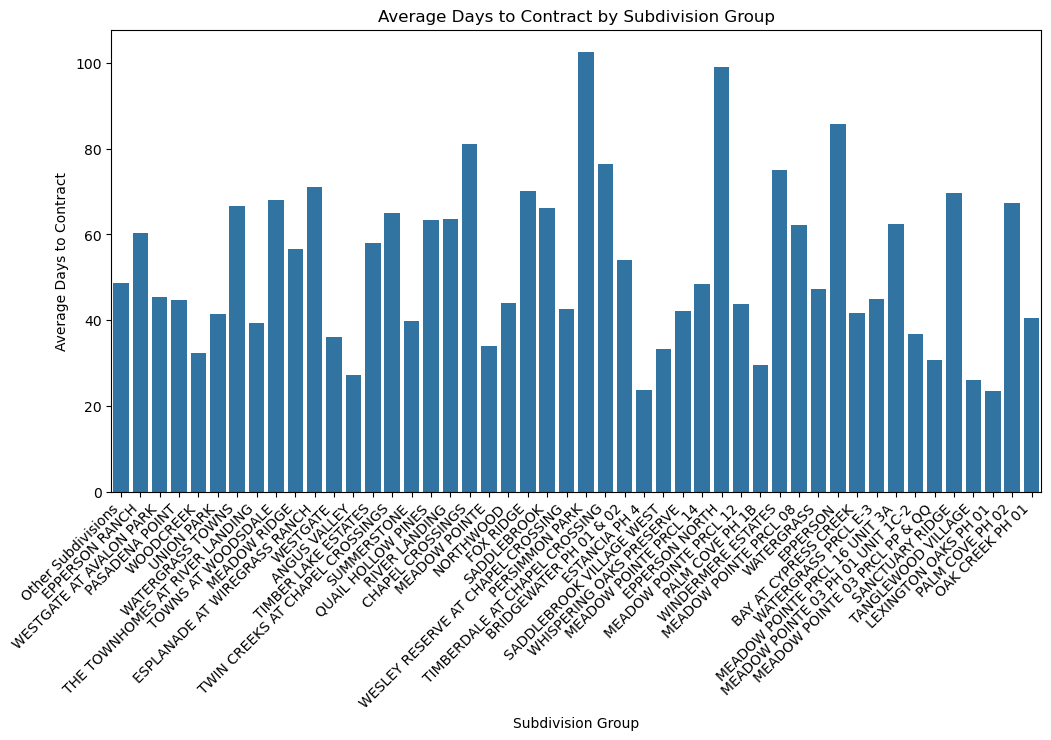

In [95]:
# Visualize average days to contract by subdivision group
plt.figure(figsize=(12, 6))
sns.barplot(x=subdivision_group_analysis.index, y=subdivision_group_analysis['Avg_Days_to_Contract'])
plt.title('Average Days to Contract by Subdivision Group')
plt.xlabel('Subdivision Group')
plt.ylabel('Average Days to Contract')
plt.xticks(rotation=45, ha='right')
plt.show()

Interpretation:
- The wide variation in prices highlights the strong impact of subdivision location and branding. Factors such as school district quality, access to shopping centers, and community facilities may drive these differences.
- Subdivisions with mid-range prices and balanced demand could offer opportunities for faster sales if priced competitively within their group. Identifying subdivisions with stable historical price appreciation may provide data-driven recommendations for sellers looking to maximize quick-sale potential.

In [97]:
sld_data.head()

,Status,City,Legal Subdivision Name,Heated Area,Current Price,Beds,Full Baths,Half Baths,Year Built,Pool,...,LP / SqFt,SP/SqFt,SP / LP,Close Month,Close Year,Close Day of Week,Contract Speed,Decade,Subdivision Group,Cleaned Subdivision
400,SLD,WESLEY CHAPEL,MEADOW POINTE PRCL 16 UNIT 02B,1184.0,156000.0,2.0,2.0,1.0,2002.0,None,...,139.36,131.76,0.95,1,2025,Thursday,Fast,2000.0,Other Subdivisions,MEADOW POINTE PRCL 16 UNIT 02B
401,SLD,WESLEY CHAPEL,FOX RIDGE,1344.0,175000.0,3.0,2.0,0.0,1983.0,None,...,148.74,130.21,0.88,12,2024,Thursday,Fast,1980.0,FOX RIDGE,FOX RIDGE
402,SLD,WESLEY CHAPEL,MEADOW POINTE PRCL 16 UNIT 3A,1240.0,225000.0,2.0,2.0,1.0,2004.0,Community,...,189.44,181.45,0.96,1,2025,Thursday,Slow,2000.0,MEADOW POINTE PRCL 16 UNIT 3A,MEADOW POINTE PRCL 16 UNIT 3A
405,SLD,WESLEY CHAPEL,MEADOW POINTE PRCL 18,2085.0,250000.0,4.0,2.0,0.0,2001.0,None,...,119.90,119.90,1.00,11,2024,Wednesday,Fast,2000.0,Other Subdivisions,MEADOW POINTE PRCL 18
410,SLD,WESLEY CHAPEL,RIVER LANDING,1373.0,269000.0,3.0,2.0,1.0,2024.0,Community,...,195.92,195.92,1.00,11,2024,Tuesday,Fast,2020.0,RIVER LANDING,RIVER LANDING


## Pre-Processing and Modeling

In [113]:
# Feature Engineering
sld_data['Year_Built_Age'] = 2025 - sld_data['Year Built']
sld_data['Price_Per_SqFt'] = sld_data['Current Price'] / sld_data['Heated Area']

In [114]:
# Cyclic encoding for month and day
sld_data['Month_Sin'] = np.sin(2 * np.pi * sld_data['Close Month'] / 12)
sld_data['Month_Cos'] = np.cos(2 * np.pi * sld_data['Close Month'] / 12)
sld_data['Day_Sin'] = np.sin(2 * np.pi * sld_data['Close Day of Week'].apply(lambda x: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'].index(x)) / 7)
sld_data['Day_Cos'] = np.cos(2 * np.pi * sld_data['Close Day of Week'].apply(lambda x: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'].index(x)) / 7)

In [115]:
speed_mapping = {'Fast': 0, 'Medium': 1, 'Slow': 2}
sld_data['Contract Speed Encoded'] = sld_data['Contract Speed'].map(speed_mapping)

In [119]:
# Define targets and features
y_days_to_contract = sld_data['Days to Contract']
y_contract_speed = sld_data['Contract Speed Encoded']
y_sp_lp_goal = (sld_data['SP / LP'] >= 1.0).astype(int)

X = sld_data[['Heated Area', 'Beds', 'Full Baths', 'Current Price', 'Price_Per_SqFt', 'Month_Sin', 'Month_Cos', 'Day_Sin', 'Day_Cos', 'Subdivision Group', 'Property Style']]

In [120]:
# Splitting data
X_train, X_test, y_train_days, y_test_days = train_test_split(X, y_days_to_contract, test_size=0.3, random_state=42)
X_train_speed, X_test_speed, y_train_speed, y_test_speed = train_test_split(X, y_contract_speed, test_size=0.3, random_state=42)
X_train_sp_lp, X_test_sp_lp, y_train_sp_lp, y_test_sp_lp = train_test_split(X, y_sp_lp_goal, test_size=0.3, random_state=42)

In [123]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Heated Area', 'Beds', 'Full Baths', 'Current Price', 'Price_Per_SqFt']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Subdivision Group'])
    ]
)

In [125]:
# Model pipelines
reg_rf = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=42))])
class_gb = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GradientBoostingClassifier(random_state=42))])
class_xgb = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))])
class_lgbm = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LGBMClassifier(random_state=42))])

In [127]:
# Hyperparameter grids
param_grid_rf = {'regressor__n_estimators': [100, 200, 300], 'regressor__max_depth': [5, 10, 15], 'regressor__min_samples_split': [2, 5, 10]}
param_grid_gb = {'classifier__n_estimators': [50, 100, 150], 'classifier__learning_rate': [0.01, 0.1], 'classifier__max_depth': [5, 10]}
param_grid_xgb = {'classifier__n_estimators': [50, 100, 150], 'classifier__learning_rate': [0.01, 0.1, 0.2], 'classifier__max_depth': [3, 5, 7]}
param_grid_lgbm = {'classifier__n_estimators': [50, 100], 'classifier__max_depth': [5, 10], 'classifier__learning_rate': [0.01, 0.1]}


In [129]:
# Model tuning
reg_search = RandomizedSearchCV(reg_rf, param_distributions=param_grid_rf, n_iter=9, scoring='neg_mean_squared_error', cv=3, random_state=42)
reg_search.fit(X_train, y_train_days)
print(f"Best params for Random Forest regressor: {reg_search.best_params_}")

Best params for Random Forest regressor: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 2, 'regressor__max_depth': 5}


In [130]:
class_search_gb = RandomizedSearchCV(class_gb, param_distributions=param_grid_gb, n_iter=8, scoring='accuracy', cv=3, random_state=42)
class_search_gb.fit(X_train_speed, y_train_speed)
print(f"Best params for Gradient Boosting classifier: {class_search_gb.best_params_}")

Best params for Gradient Boosting classifier: {'classifier__n_estimators': 150, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.01}


In [131]:
class_search_xgb = RandomizedSearchCV(class_xgb, param_distributions=param_grid_xgb, n_iter=8, scoring='accuracy', cv=3, random_state=42)
class_search_xgb.fit(X_train_speed, y_train_speed)
print(f"Best params for XGBoost classifier: {class_search_xgb.best_params_}")

Best params for XGBoost classifier: {'classifier__n_estimators': 150, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}


In [132]:
class_search_lgbm = RandomizedSearchCV(class_lgbm, param_distributions=param_grid_lgbm, n_iter=8, scoring='accuracy', cv=3, random_state=42)
class_search_lgbm.fit(X_train_speed, y_train_speed)
print(f"Best params for LightGBM classifier: {class_search_lgbm.best_params_}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 800
[LightGBM] [Info] Number of data points in the train set: 1474, number of used features: 17
[LightGBM] [Info] Start training from score -1.138756
[LightGBM] [Info] Start training from score -1.324473
[LightGBM] [Info] Start training from score -0.882276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

In [133]:
#  Class balancing with SMOTEENN
balance_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversample', SMOTEENN(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

balance_pipeline.fit(X_train_sp_lp, y_train_sp_lp)
y_pred_balanced = balance_pipeline.predict(X_test_sp_lp)
print('SP/LP Goal Balanced Classification Report:\n', classification_report(y_test_sp_lp, y_pred_balanced))

SP/LP Goal Balanced Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.81      0.68       419
           1       0.79      0.55      0.64       530

    accuracy                           0.66       949
   macro avg       0.69      0.68      0.66       949
weighted avg       0.70      0.66      0.66       949



In [170]:
# Evaluate models
#  Days to Contract
y_pred_days = reg_search.best_estimator_.predict(X_test)
days_rmse = np.sqrt(mean_squared_error(y_test_days, y_pred_days))
days_r2 = r2_score(y_test_days, y_pred_days)
print(f"\nDays to Contract - RMSE: {days_rmse:.2f}, R2: {days_r2:.2f}")


Days to Contract - RMSE: 51.60, R2: 0.02


In [147]:
# Contract Speed (Gradient Boosting)
y_pred_speed_gb = class_search_gb.best_estimator_.predict(X_test_speed)
print('Contract Speed Classification Report (Gradient Boosting):\n', classification_report(y_test_speed, y_pred_speed_gb))

Contract Speed Classification Report (Gradient Boosting):
               precision    recall  f1-score   support

           0       0.35      0.17      0.23       290
           1       0.25      0.05      0.09       272
           2       0.42      0.82      0.56       387

    accuracy                           0.40       949
   macro avg       0.34      0.35      0.29       949
weighted avg       0.35      0.40      0.32       949



In [149]:
# Contract Speed (XGBoost)
y_pred_speed_xgb = class_search_xgb.best_estimator_.predict(X_test_speed)
print('Contract Speed Classification Report (XGBoost):\n', classification_report(y_test_speed, y_pred_speed_xgb))

Contract Speed Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.40      0.30      0.34       290
           1       0.23      0.08      0.12       272
           2       0.44      0.72      0.55       387

    accuracy                           0.41       949
   macro avg       0.36      0.37      0.34       949
weighted avg       0.37      0.41      0.36       949



In [153]:
# Contract Speed Classification (LightGBM)
y_pred_speed_lgbm = class_search_lgbm.best_estimator_.predict(X_test_speed)
print("\nContract Speed Classification Report (LightGBM):")
print(classification_report(y_test_speed, y_pred_speed_lgbm))


Contract Speed Classification Report (LightGBM):
              precision    recall  f1-score   support

           0       0.44      0.20      0.28       290
           1       0.20      0.03      0.06       272
           2       0.43      0.85      0.57       387

    accuracy                           0.42       949
   macro avg       0.36      0.36      0.30       949
weighted avg       0.37      0.42      0.33       949



In [155]:
# SP/LP Goal Balanced
print('SP/LP Goal Balanced Classification Report:\n', classification_report(y_test_sp_lp, y_pred_balanced))


SP/LP Goal Balanced Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.81      0.68       419
           1       0.79      0.55      0.64       530

    accuracy                           0.66       949
   macro avg       0.69      0.68      0.66       949
weighted avg       0.70      0.66      0.66       949



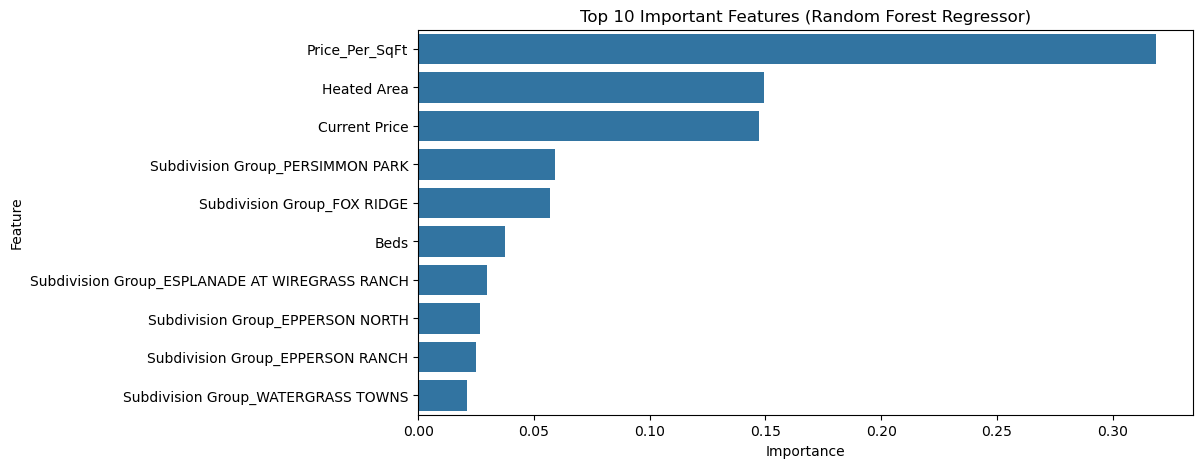

In [168]:
# Visualization

preprocessor_fitted = reg_search.best_estimator_.named_steps['preprocessor']
num_features = ['Heated Area', 'Beds', 'Full Baths', 'Current Price', 'Price_Per_SqFt']
cat_features = preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(['Subdivision Group'])

all_feature_names = np.concatenate([num_features, cat_features])



feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': reg_search.best_estimator_.named_steps['regressor'].feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Important Features (Random Forest Regressor)')
plt.show()

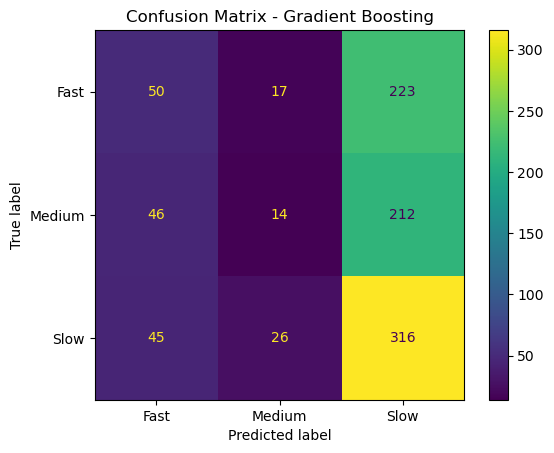

In [162]:
# Gradient Boosting Confusion Matrix
ConfusionMatrixDisplay.from_estimator(class_search_gb.best_estimator_, X_test_speed, y_test_speed, display_labels=['Fast', 'Medium', 'Slow'])
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()

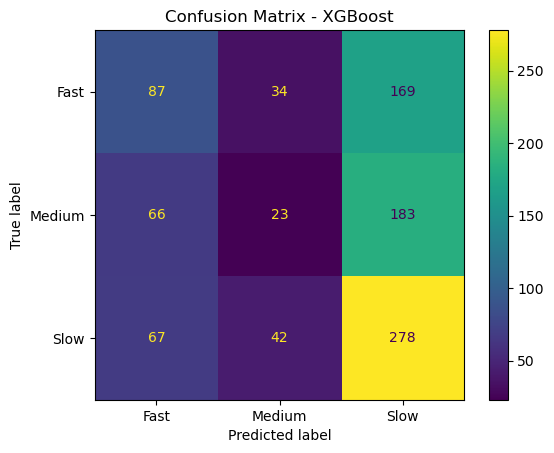

In [164]:
# XGBoost Confusion Matrix
ConfusionMatrixDisplay.from_estimator(class_search_xgb.best_estimator_, X_test_speed, y_test_speed, display_labels=['Fast', 'Medium', 'Slow'])
plt.title('Confusion Matrix - XGBoost')
plt.show()

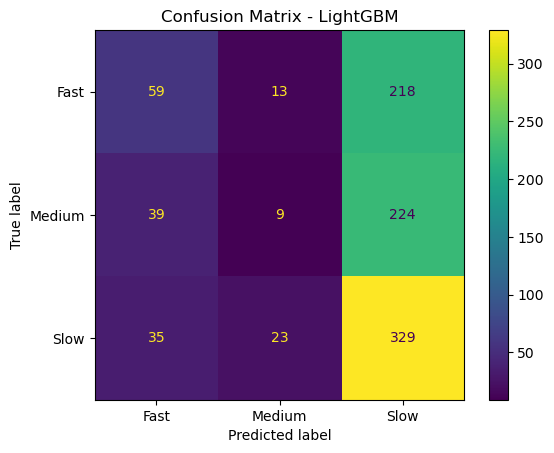

In [165]:
# LightGBM Confusion Matrix
ConfusionMatrixDisplay.from_estimator(class_search_lgbm.best_estimator_, X_test_speed, y_test_speed, display_labels=['Fast', 'Medium', 'Slow'])
plt.title('Confusion Matrix - LightGBM')
plt.show()